In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

%matplotlib inline: 이 라인은 Jupyter Notebook에서 matplotlib 그래프를 인라인으로 표시하도록 지정합니다. 이는 그래프가 코드 셀 아래에 바로 나타나게 하는 명령입니다.

%config InlineBackend.figure_format = "retina": 이 라인은 그래프의 해상도를 개선하기 위해 "retina" 해상도를 사용하도록 지정합니다. 특히, Retina 디스플레이를 갖춘 장치에서는 고해상도 그래픽을 지원합니다.

register_matplotlib_converters(): 이 라인은 날짜와 관련된 데이터를 다룰 때 matplotlib이 제대로 작동하도록 하는 등록 작업을 수행합니다.

sns.set(style="whitegrid", palette="muted", font_scale=1.5): Seaborn 라이브러리를 사용하여 시각화의 기본 스타일을 설정합니다. whitegrid는 흰 배경에 격자 라인이 있는 스타일을 사용하도록 설정하고, muted는 부드러운 색상 팔레트를 사용하도록 지정합니다. font_scale=1.5는 글꼴 크기를 1.5배로 설정합니다.

rcParams["figure.figsize"] = 22, 10: matplotlib의 rcParams를 사용하여 기본적인 그림 크기를 설정합니다. figure.figsize는 가로와 세로 크기를 나타내며, 여기서는 (22, 10)으로 설정되어 있습니다.

In [2]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["NaN", "user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]
data = pd.read_csv("C:\AI_study\WISDM.csv", header=None, names=names, skiprows=1)

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

(1098203, 6)


In [5]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098202
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float64
 4   y_axis     1098203 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [7]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098198,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,4
1098199,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,4
1098200,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,4
1098201,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,4


<AxesSubplot:xlabel='activity', ylabel='count'>

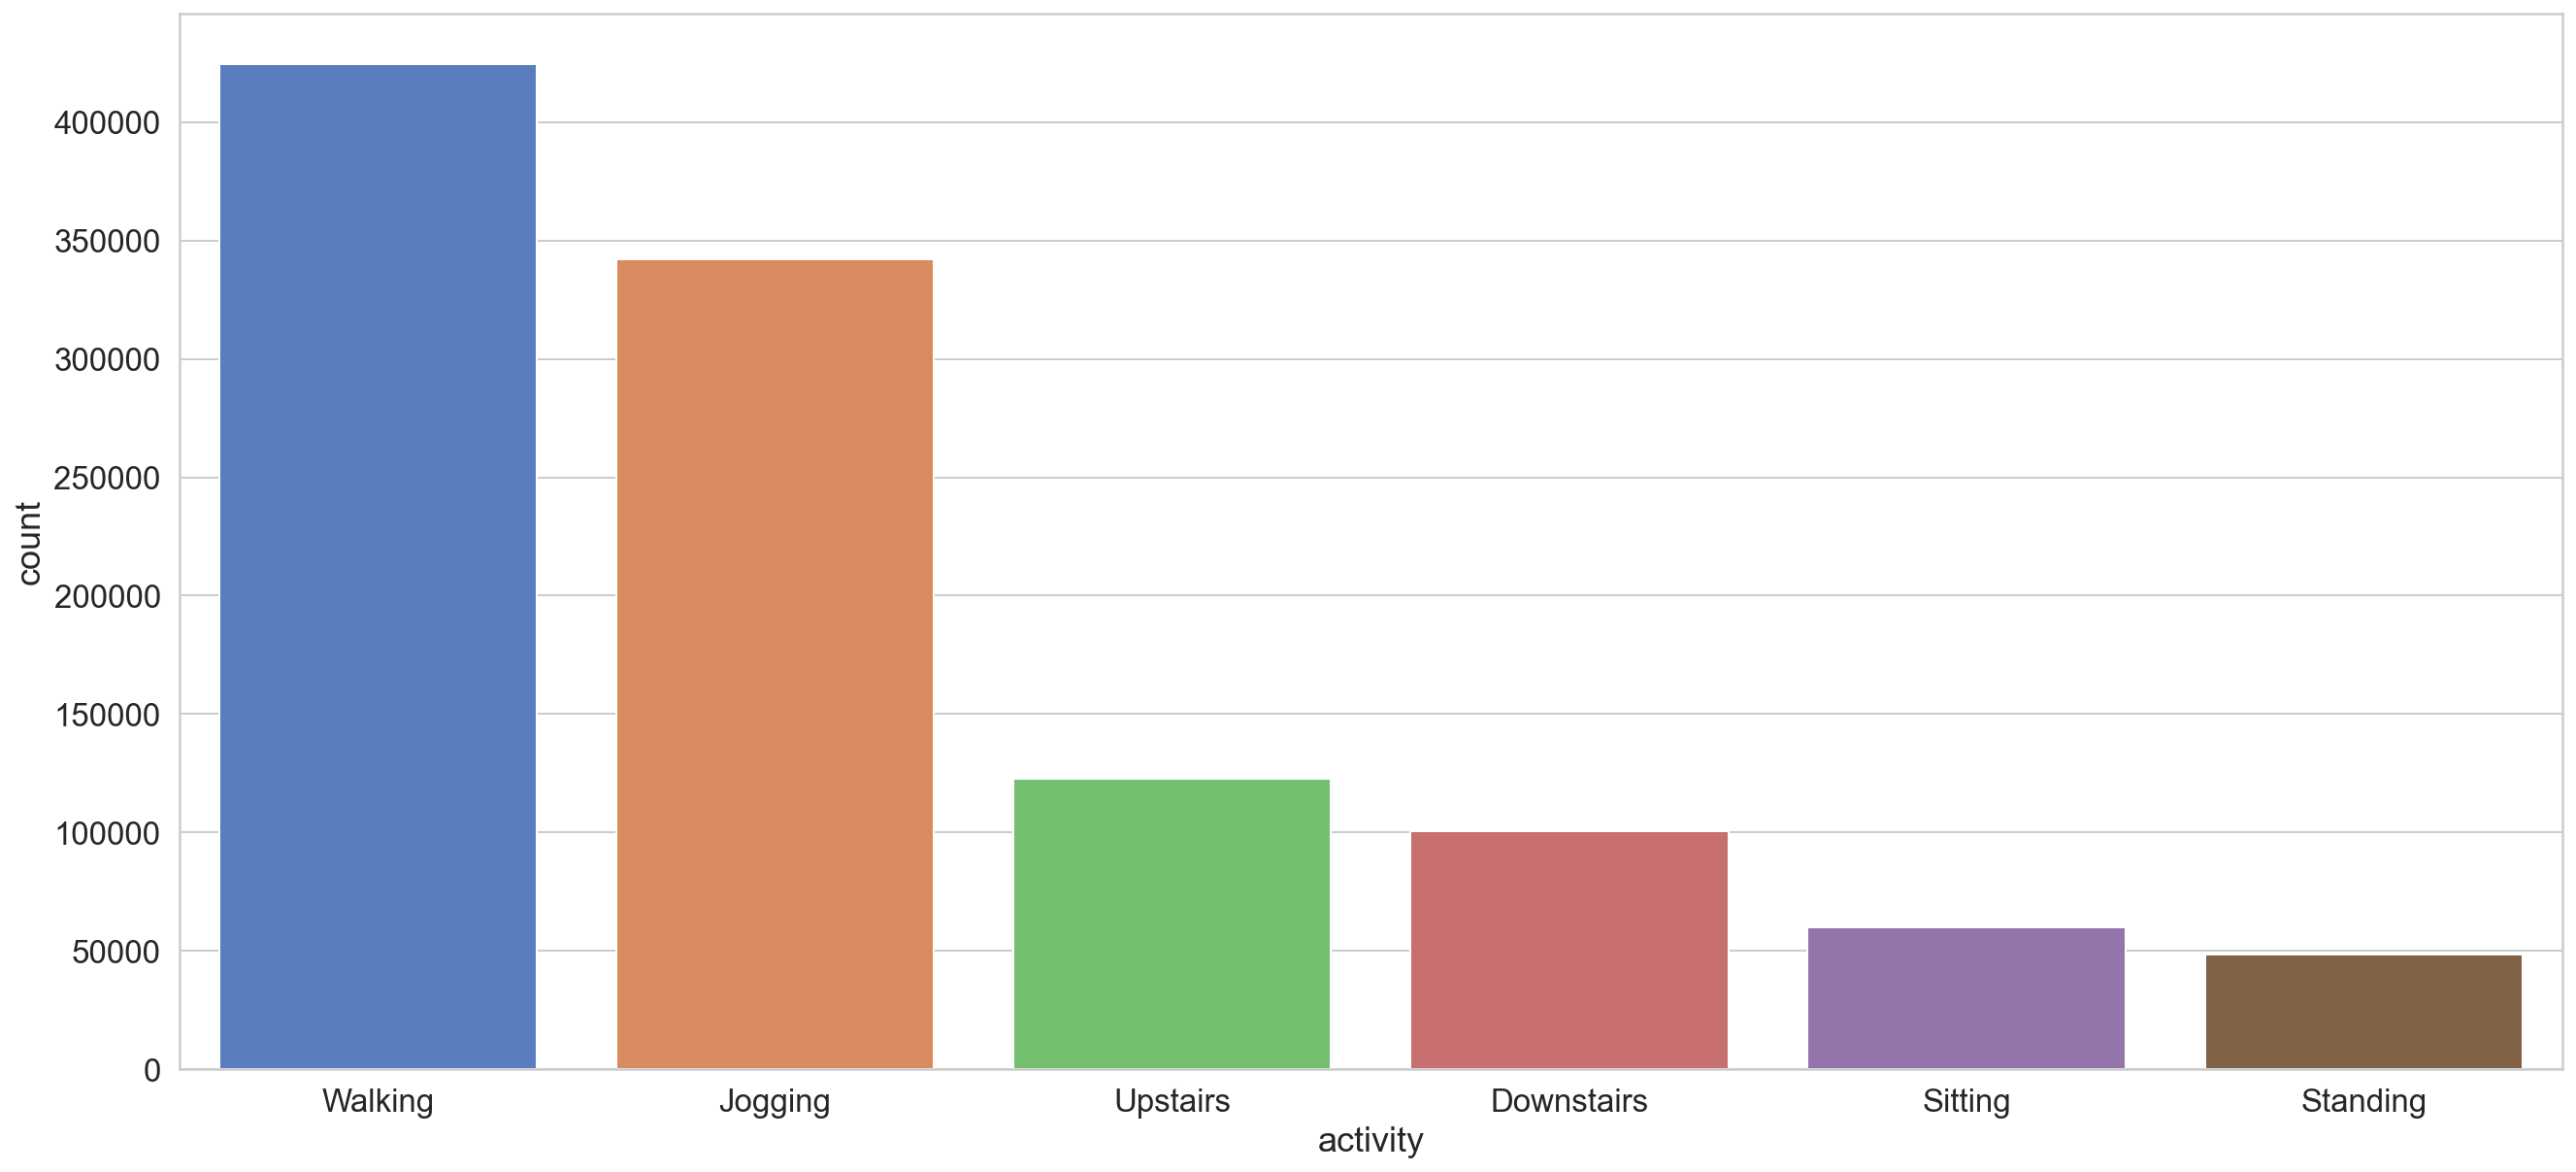

In [8]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

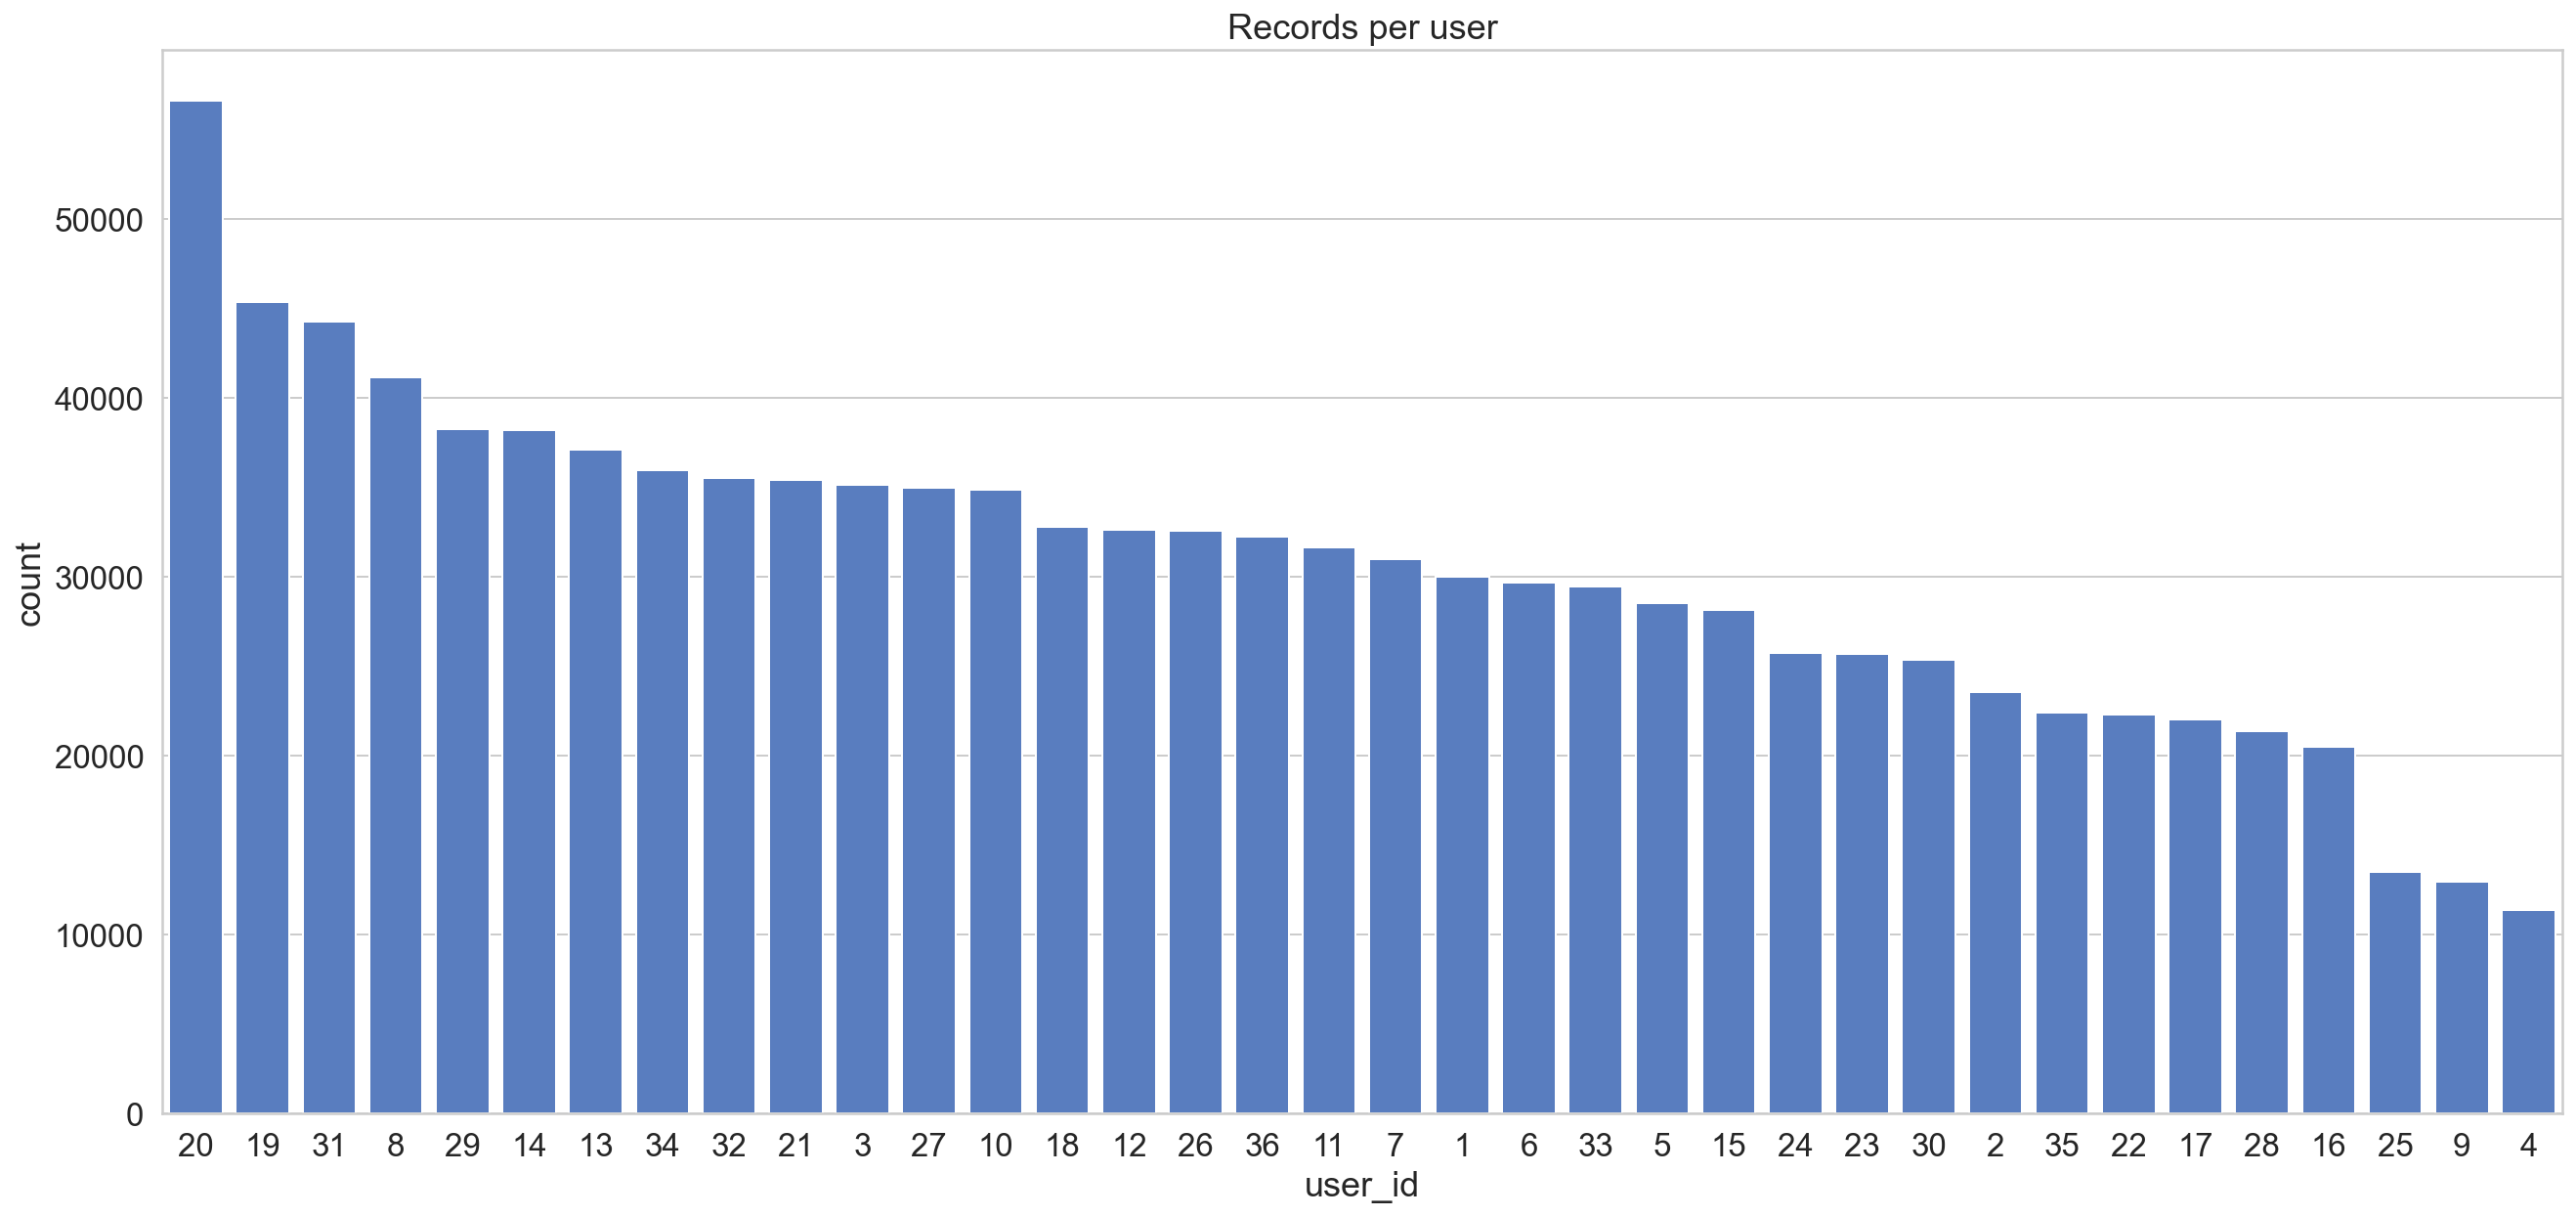

In [9]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");

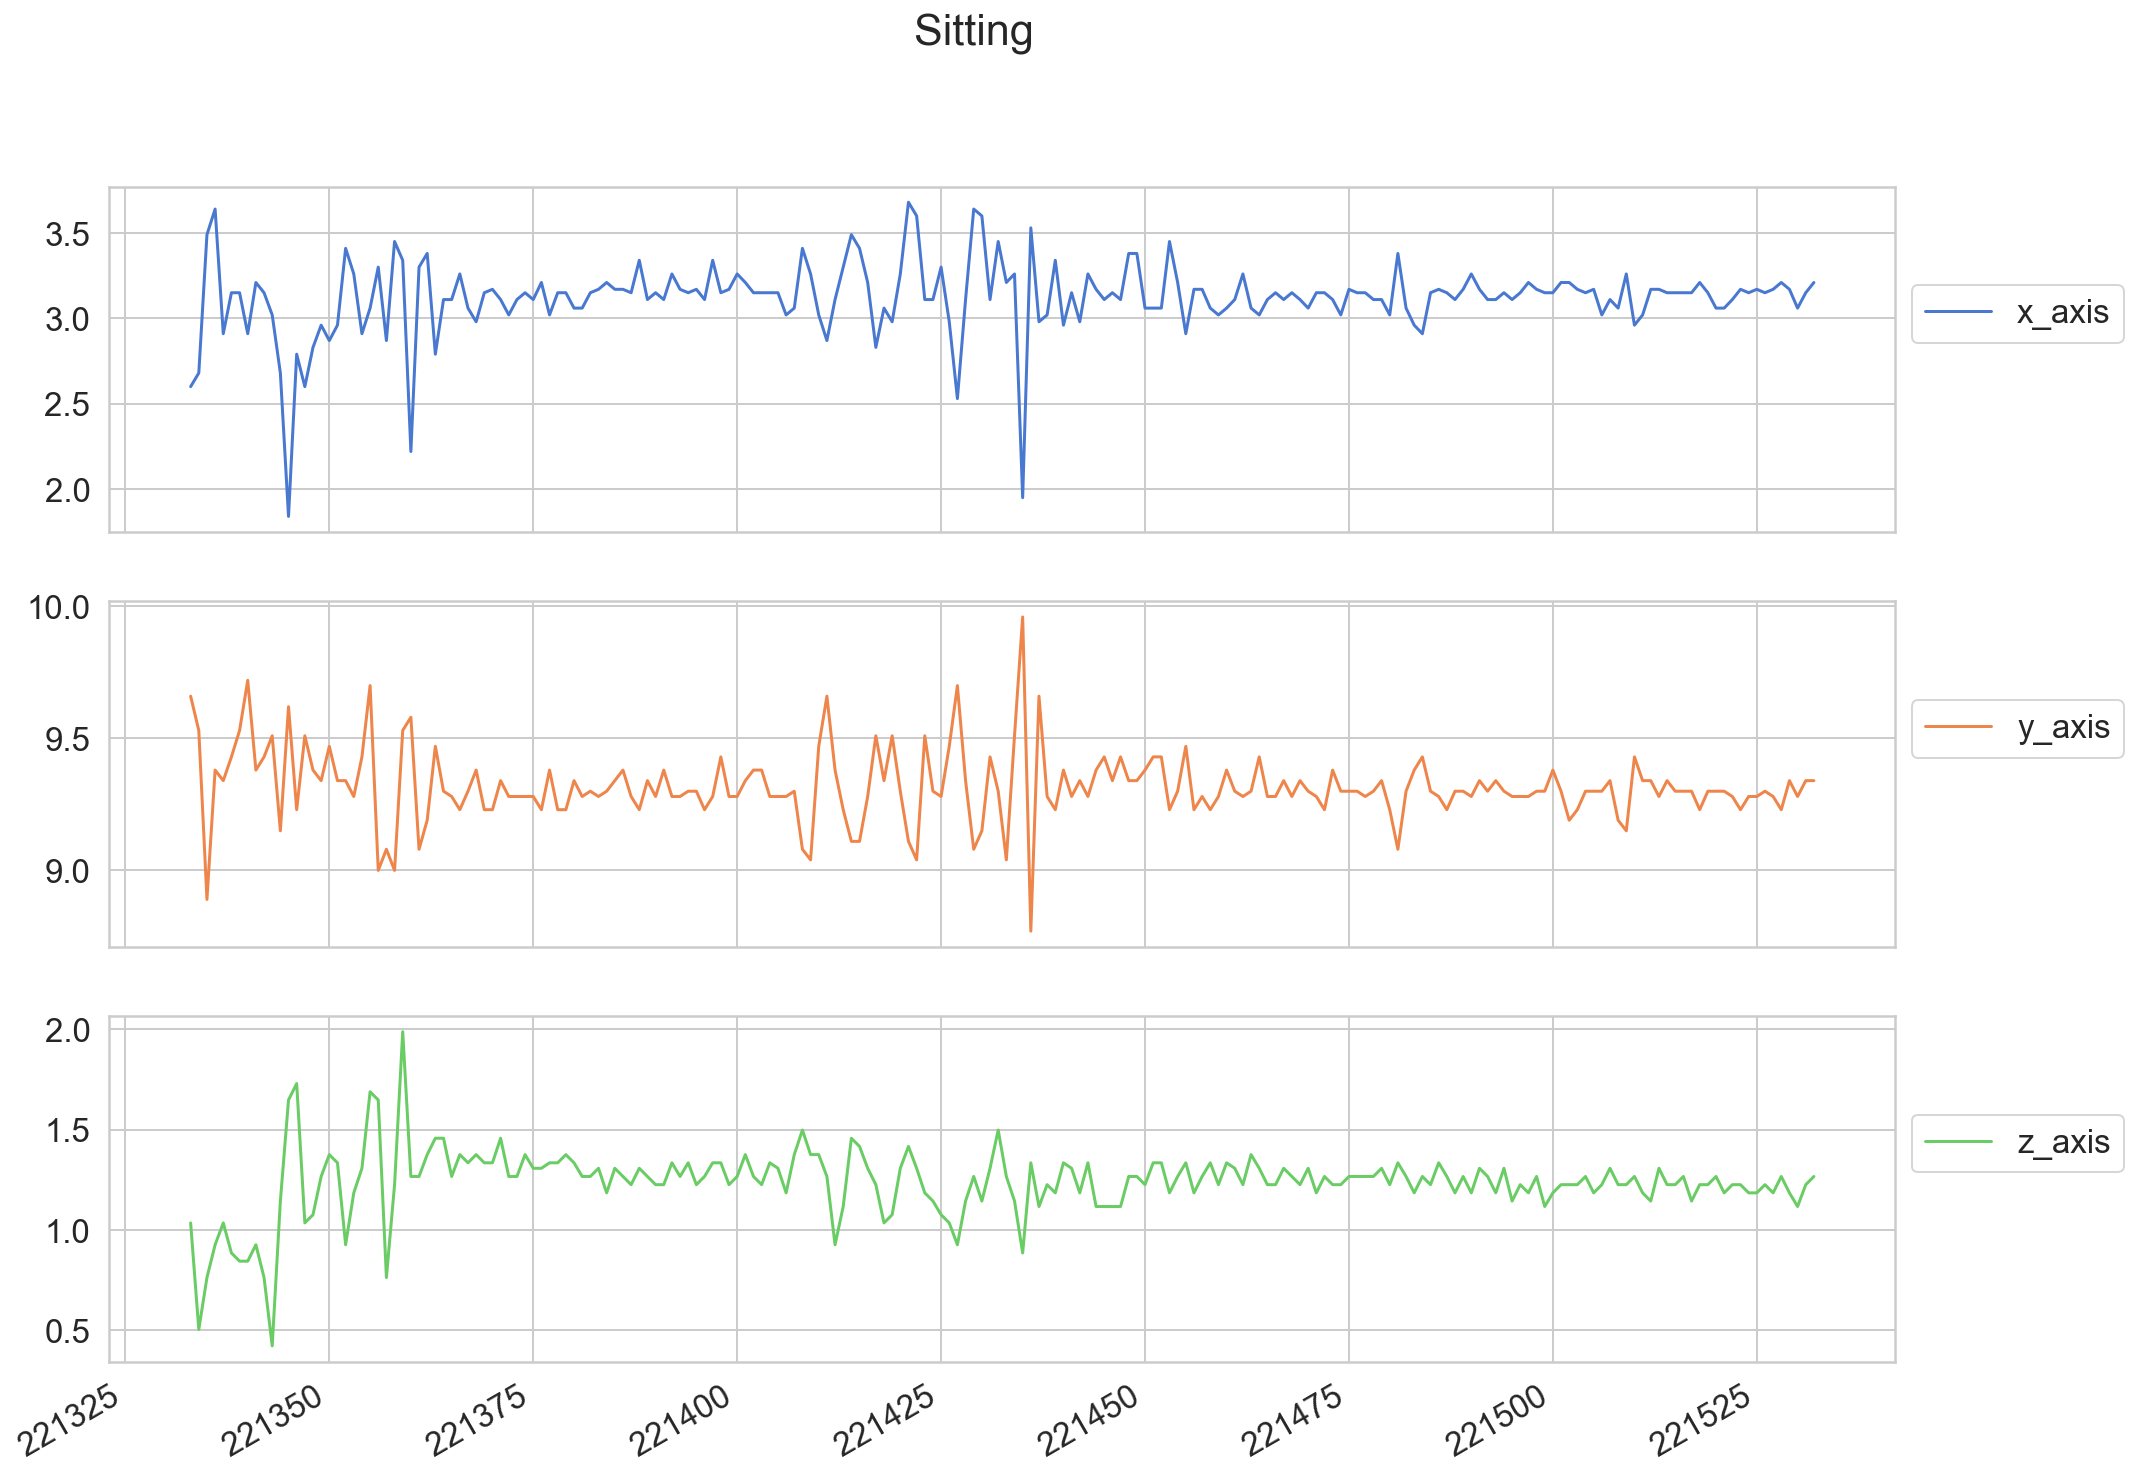

In [10]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)

In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.131961,0.566215,0.102015,1
1,33,Jogging,49106062271000,0.648740,0.397381,0.193001,1
2,33,Jogging,49106112167000,0.633834,0.351926,-0.016543,1
3,33,Jogging,49106222305000,-0.120782,1.259408,0.612089,1
4,33,Jogging,49106332290000,-0.199038,0.498032,1.458535,1
...,...,...,...,...,...,...,...
1098198,19,Sitting,131623331483000,1.194254,-1.132300,0.342105,4
1098199,19,Sitting,131623371431000,1.199726,-1.119190,0.350202,4
1098200,19,Sitting,131623411592000,1.205198,-1.109654,0.342105,4
1098201,19,Sitting,131623491487000,1.194254,-1.119190,0.350202,4


In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17568, 200, 3) (17568, 1)
(5491, 200, 3) (5491, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(17568, 200, 3) (17568, 6) (5491, 200, 3) (5491, 6)


In [14]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 6)

In [15]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 198, 64)           640       
_________________________________________________________________
flatten (Flatten)            (None, 12672)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1622144   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 1,623,558
Trainable params: 1,623,558
Non-trainable params: 0
_________________________________________________________________


In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
138/138 [==============================] - 5s 29ms/step - loss: 0.7450 - accuracy: 0.7317 - val_loss: 0.4783 - val_accuracy: 0.8240
Epoch 2/10
138/138 [==============================] - 4s 27ms/step - loss: 0.3696 - accuracy: 0.8658 - val_loss: 0.4077 - val_accuracy: 0.8495
Epoch 3/10
138/138 [==============================] - 4s 28ms/step - loss: 0.2608 - accuracy: 0.9070 - val_loss: 0.3373 - val_accuracy: 0.8770
Epoch 4/10
138/138 [==============================] - 4s 27ms/step - loss: 0.1839 - accuracy: 0.9357 - val_loss: 0.3461 - val_accuracy: 0.8796
Epoch 5/10
138/138 [==============================] - 4s 28ms/step - loss: 0.1282 - accuracy: 0.9583 - val_loss: 0.3057 - val_accuracy: 0.9037
Epoch 6/10
138/138 [==============================] - 4s 27ms/step - loss: 0.0916 - accuracy: 0.9738 - val_loss: 0.2971 - val_accuracy: 0.9046
Epoch 7/10
138/138 [==============================] - 4s 27ms/step - loss: 0.0684 - accuracy: 0.9821 - val_loss: 0.3131 - val_accuracy: 0.8969

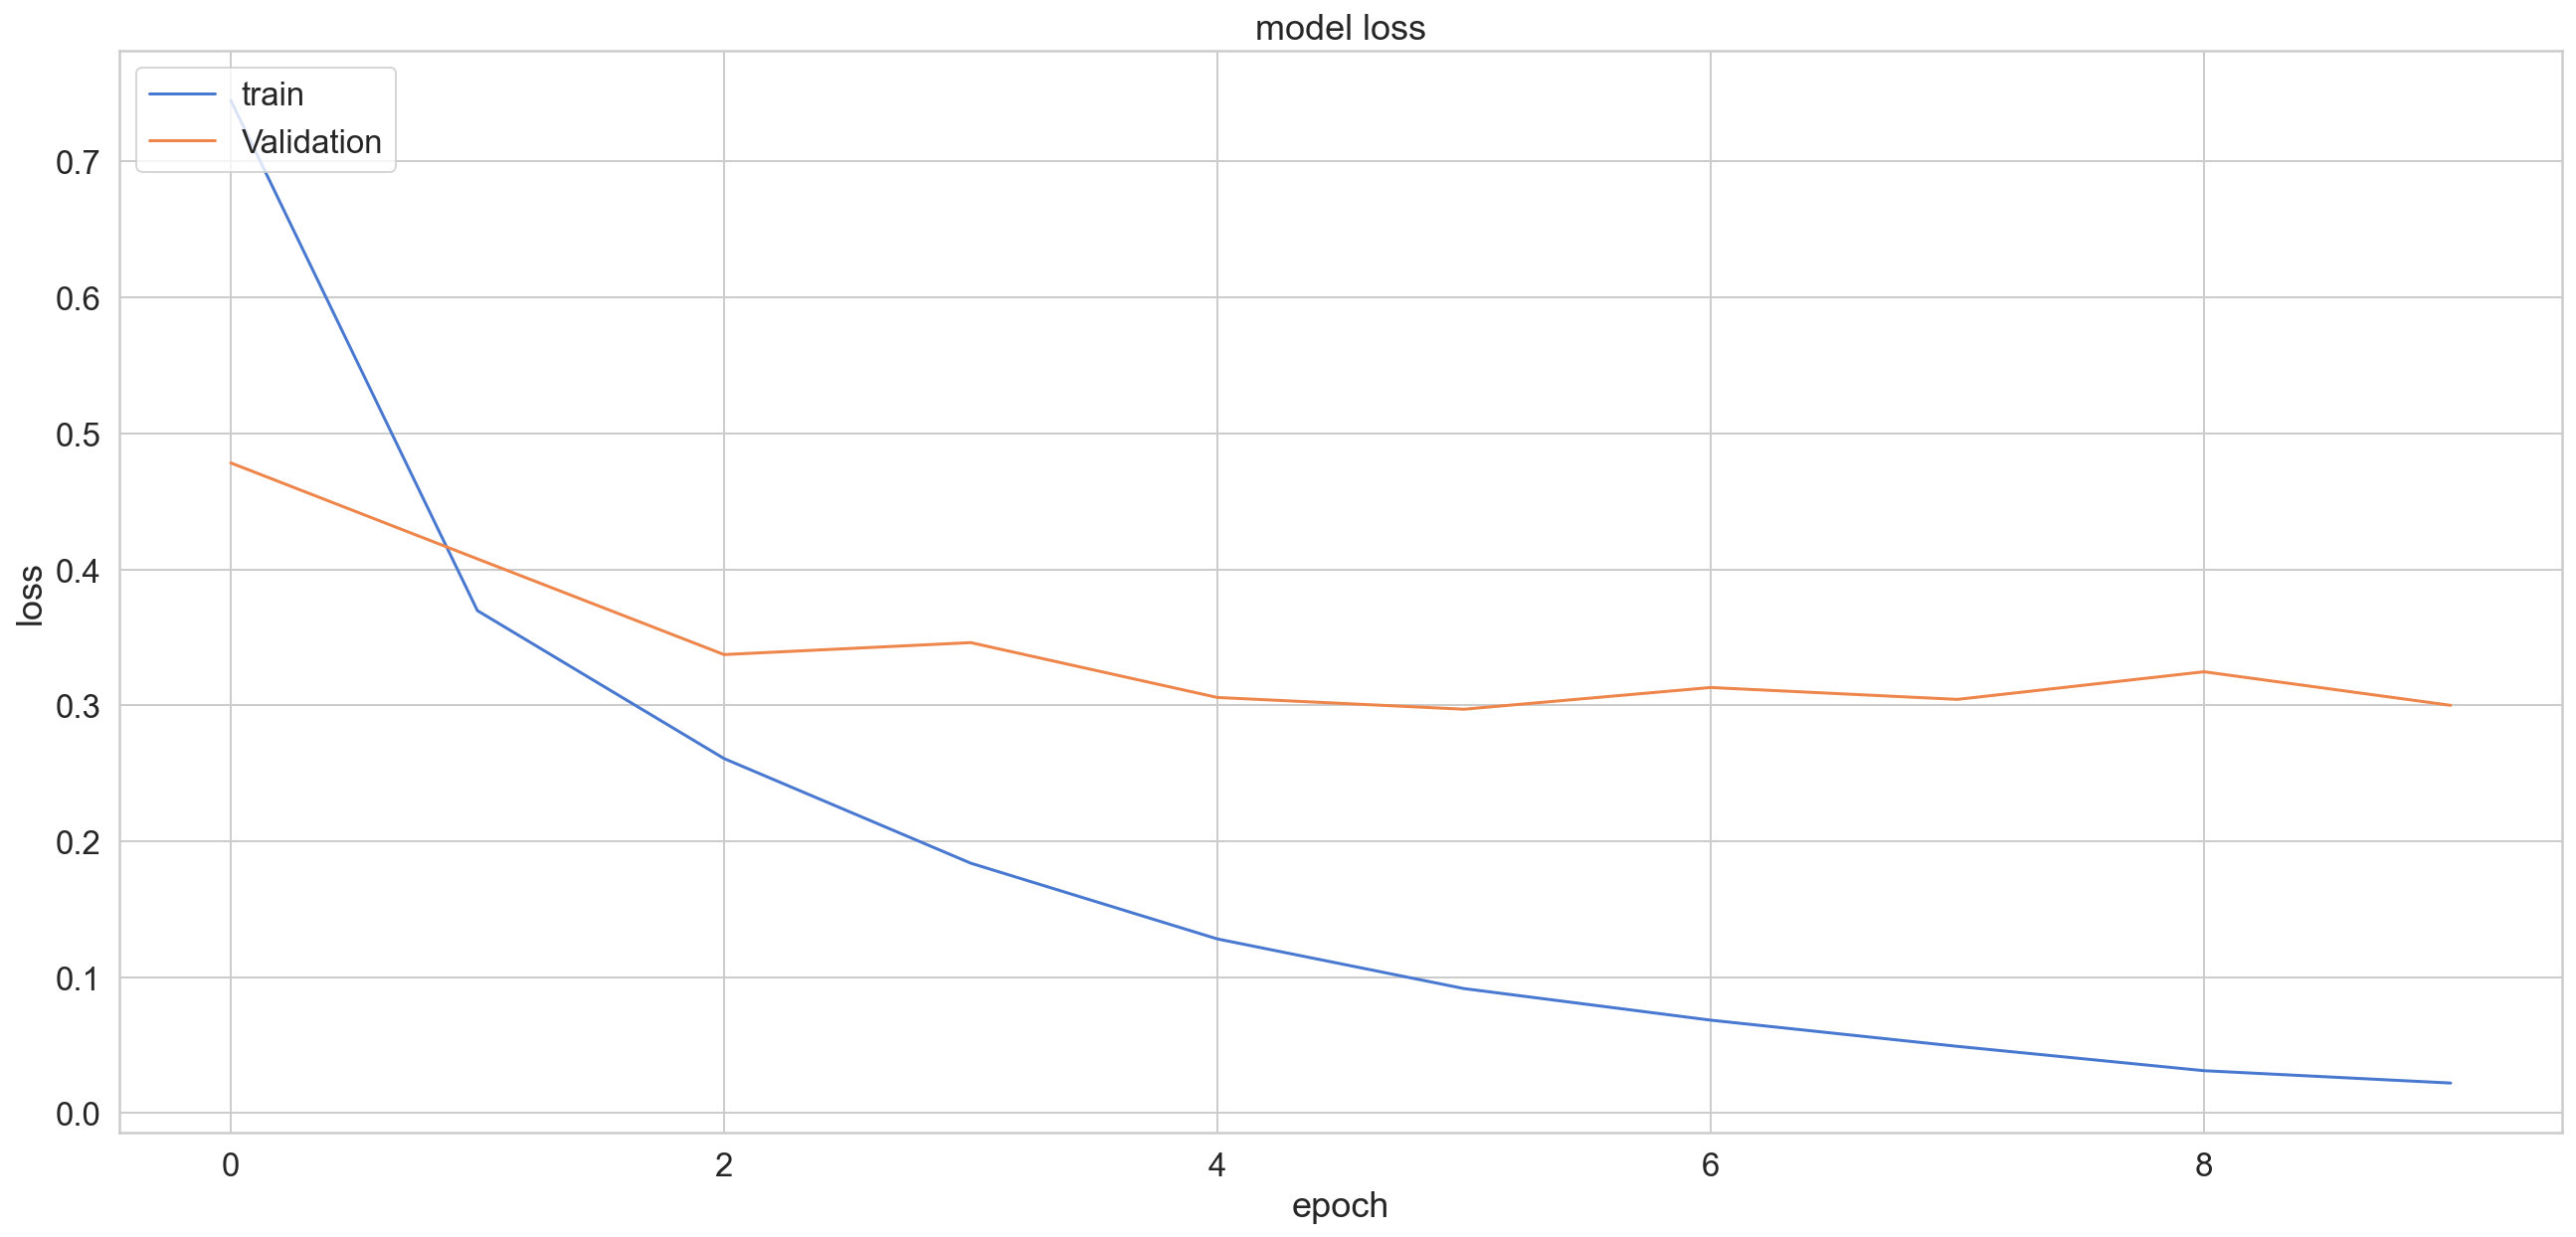

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

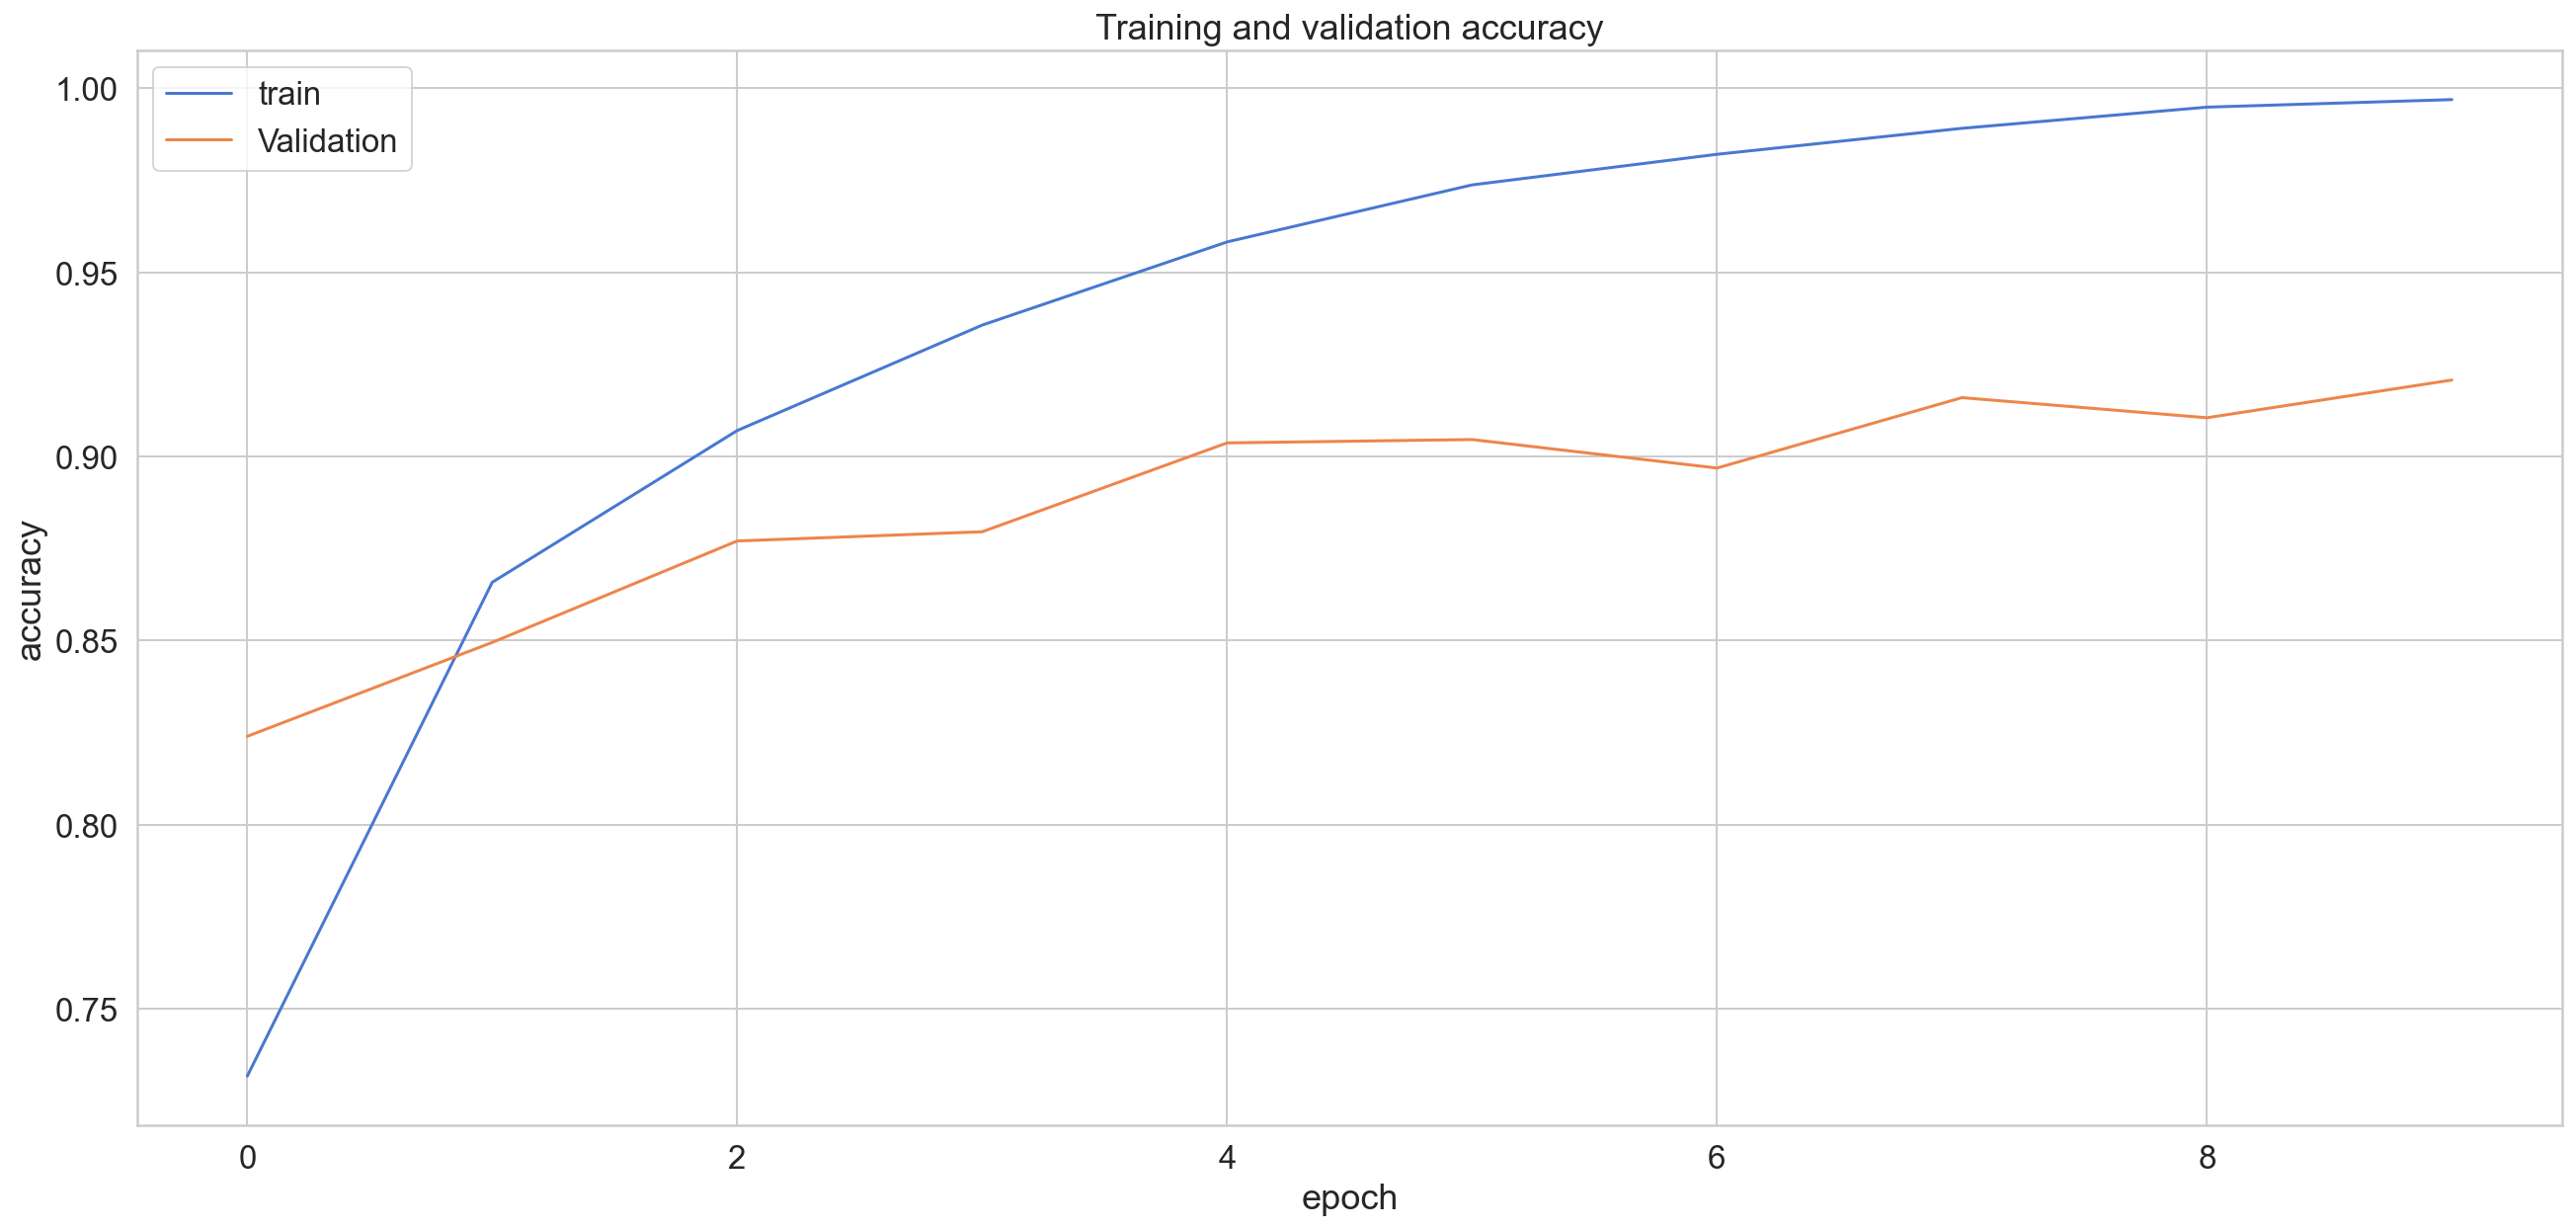

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

f1_score =  0.918765906805518
0.9198688763431069
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2123
           1       0.97      0.97      0.97      1710
           2       0.76      0.72      0.74       614
           3       0.75      0.71      0.73       502
           4       0.99      0.97      0.98       300
           5       0.98      0.98      0.98       242

    accuracy                           0.92      5491
   macro avg       0.90      0.89      0.89      5491
weighted avg       0.92      0.92      0.92      5491



<AxesSubplot:>

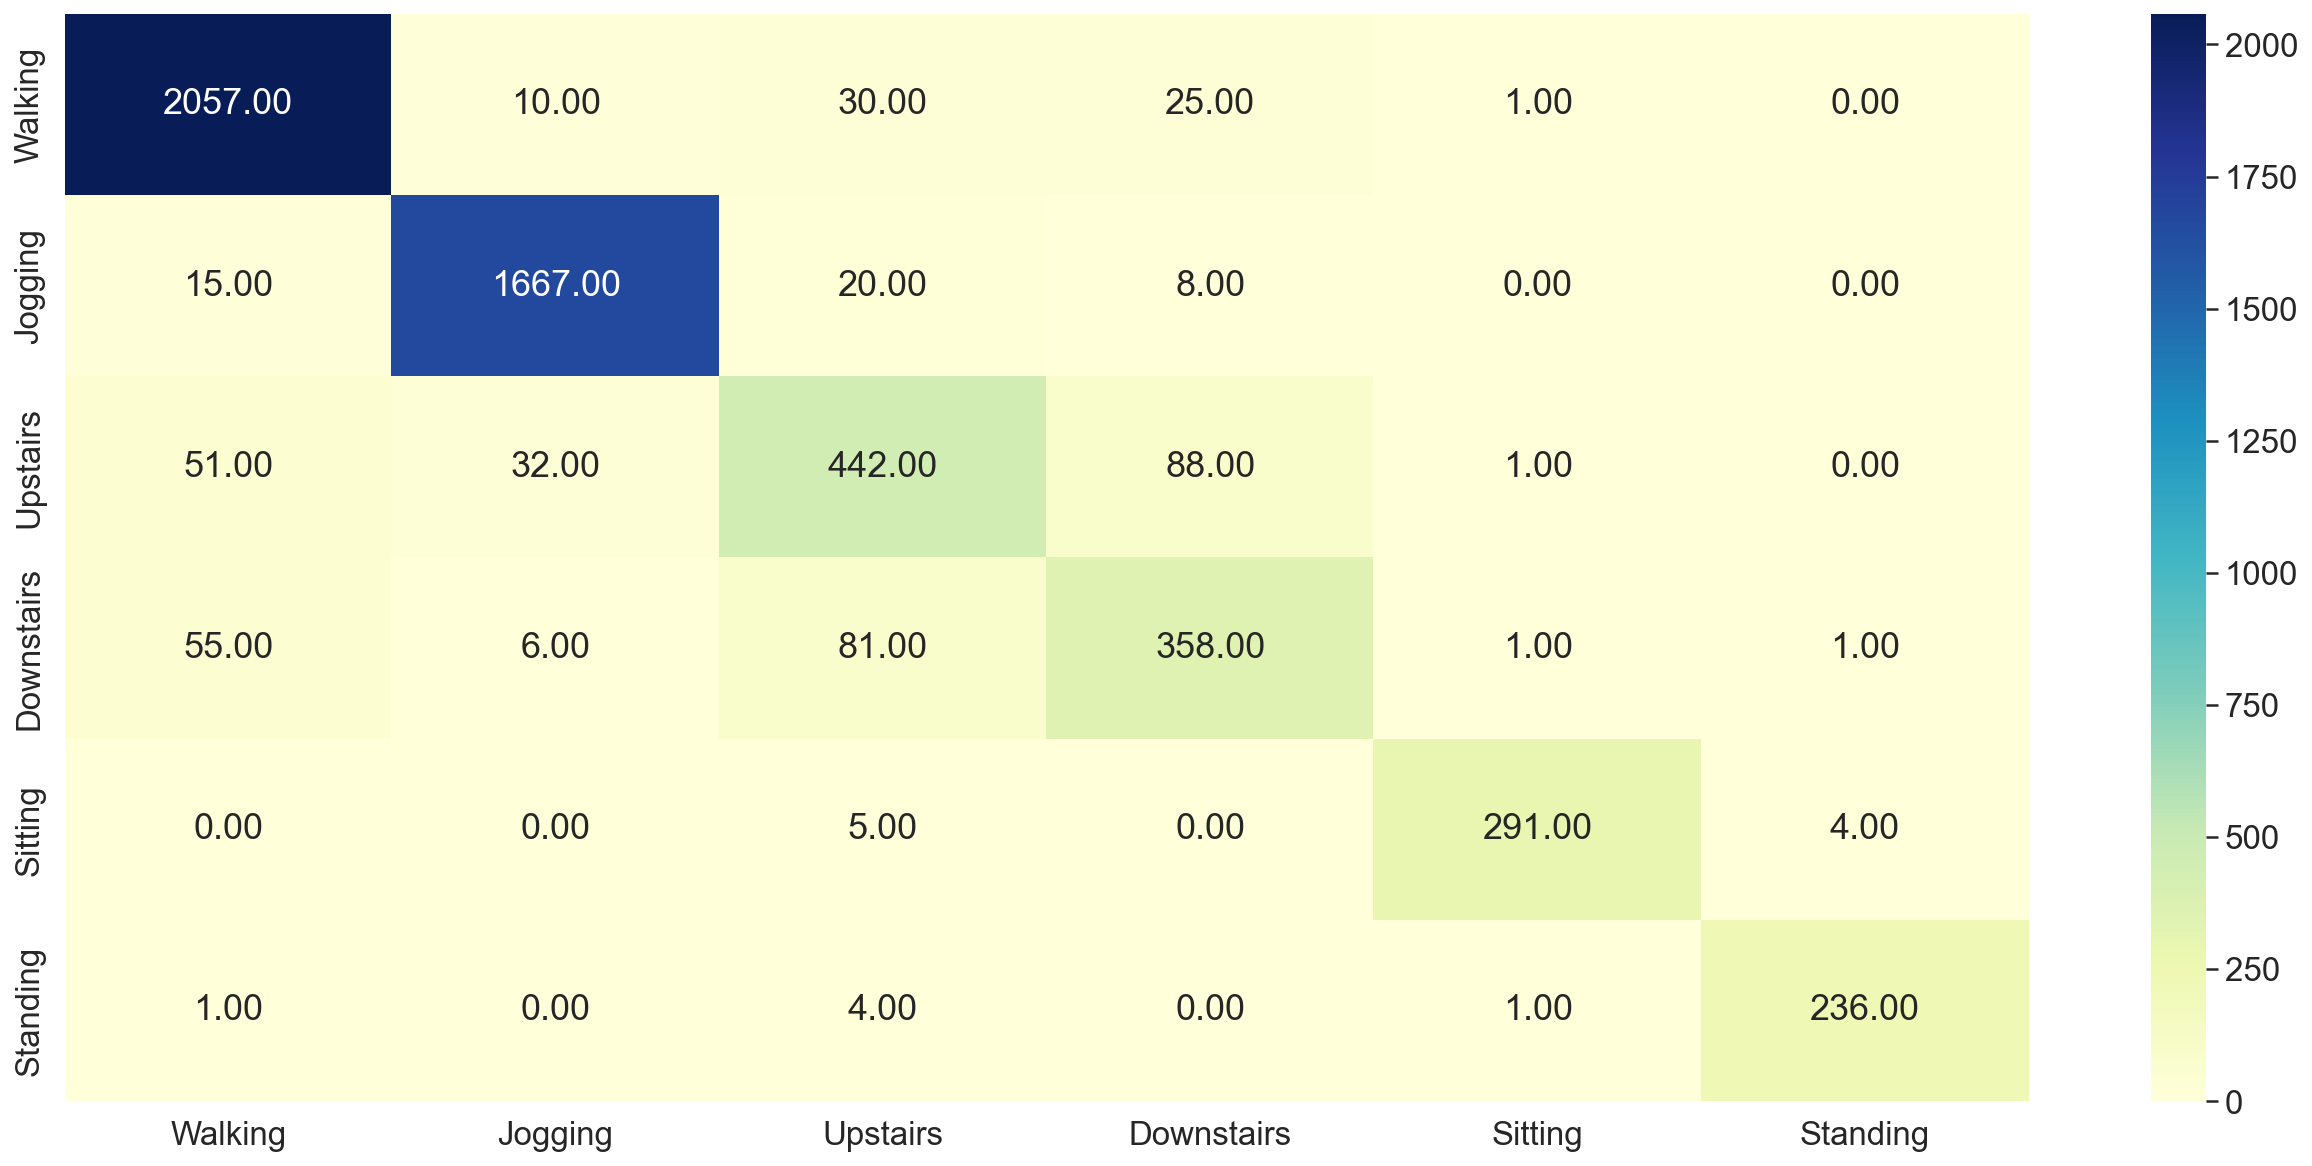

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 2</h1>

In [20]:
# Model 2
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 198, 64)           640       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 64)           12352     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 1,619,526
Trainable params: 1,619,526
Non-trainable params: 0
_________________________________________________________________


In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
138/138 [==============================] - 9s 60ms/step - loss: 0.6373 - accuracy: 0.7580 - val_loss: 0.3504 - val_accuracy: 0.8786
Epoch 2/10
138/138 [==============================] - 8s 57ms/step - loss: 0.2531 - accuracy: 0.9084 - val_loss: 0.2495 - val_accuracy: 0.9096
Epoch 3/10
138/138 [==============================] - 8s 58ms/step - loss: 0.1556 - accuracy: 0.9481 - val_loss: 0.2267 - val_accuracy: 0.9251
Epoch 4/10
138/138 [==============================] - 8s 58ms/step - loss: 0.0908 - accuracy: 0.9710 - val_loss: 0.1727 - val_accuracy: 0.9440
Epoch 5/10
138/138 [==============================] - 8s 58ms/step - loss: 0.0552 - accuracy: 0.9855 - val_loss: 0.1790 - val_accuracy: 0.9372
Epoch 6/10
138/138 [==============================] - 8s 58ms/step - loss: 0.0428 - accuracy: 0.9885 - val_loss: 0.1641 - val_accuracy: 0.9456
Epoch 7/10
138/138 [==============================] - 8s 58ms/step - loss: 0.0195 - accuracy: 0.9966 - val_loss: 0.1809 - val_accuracy: 0.9469

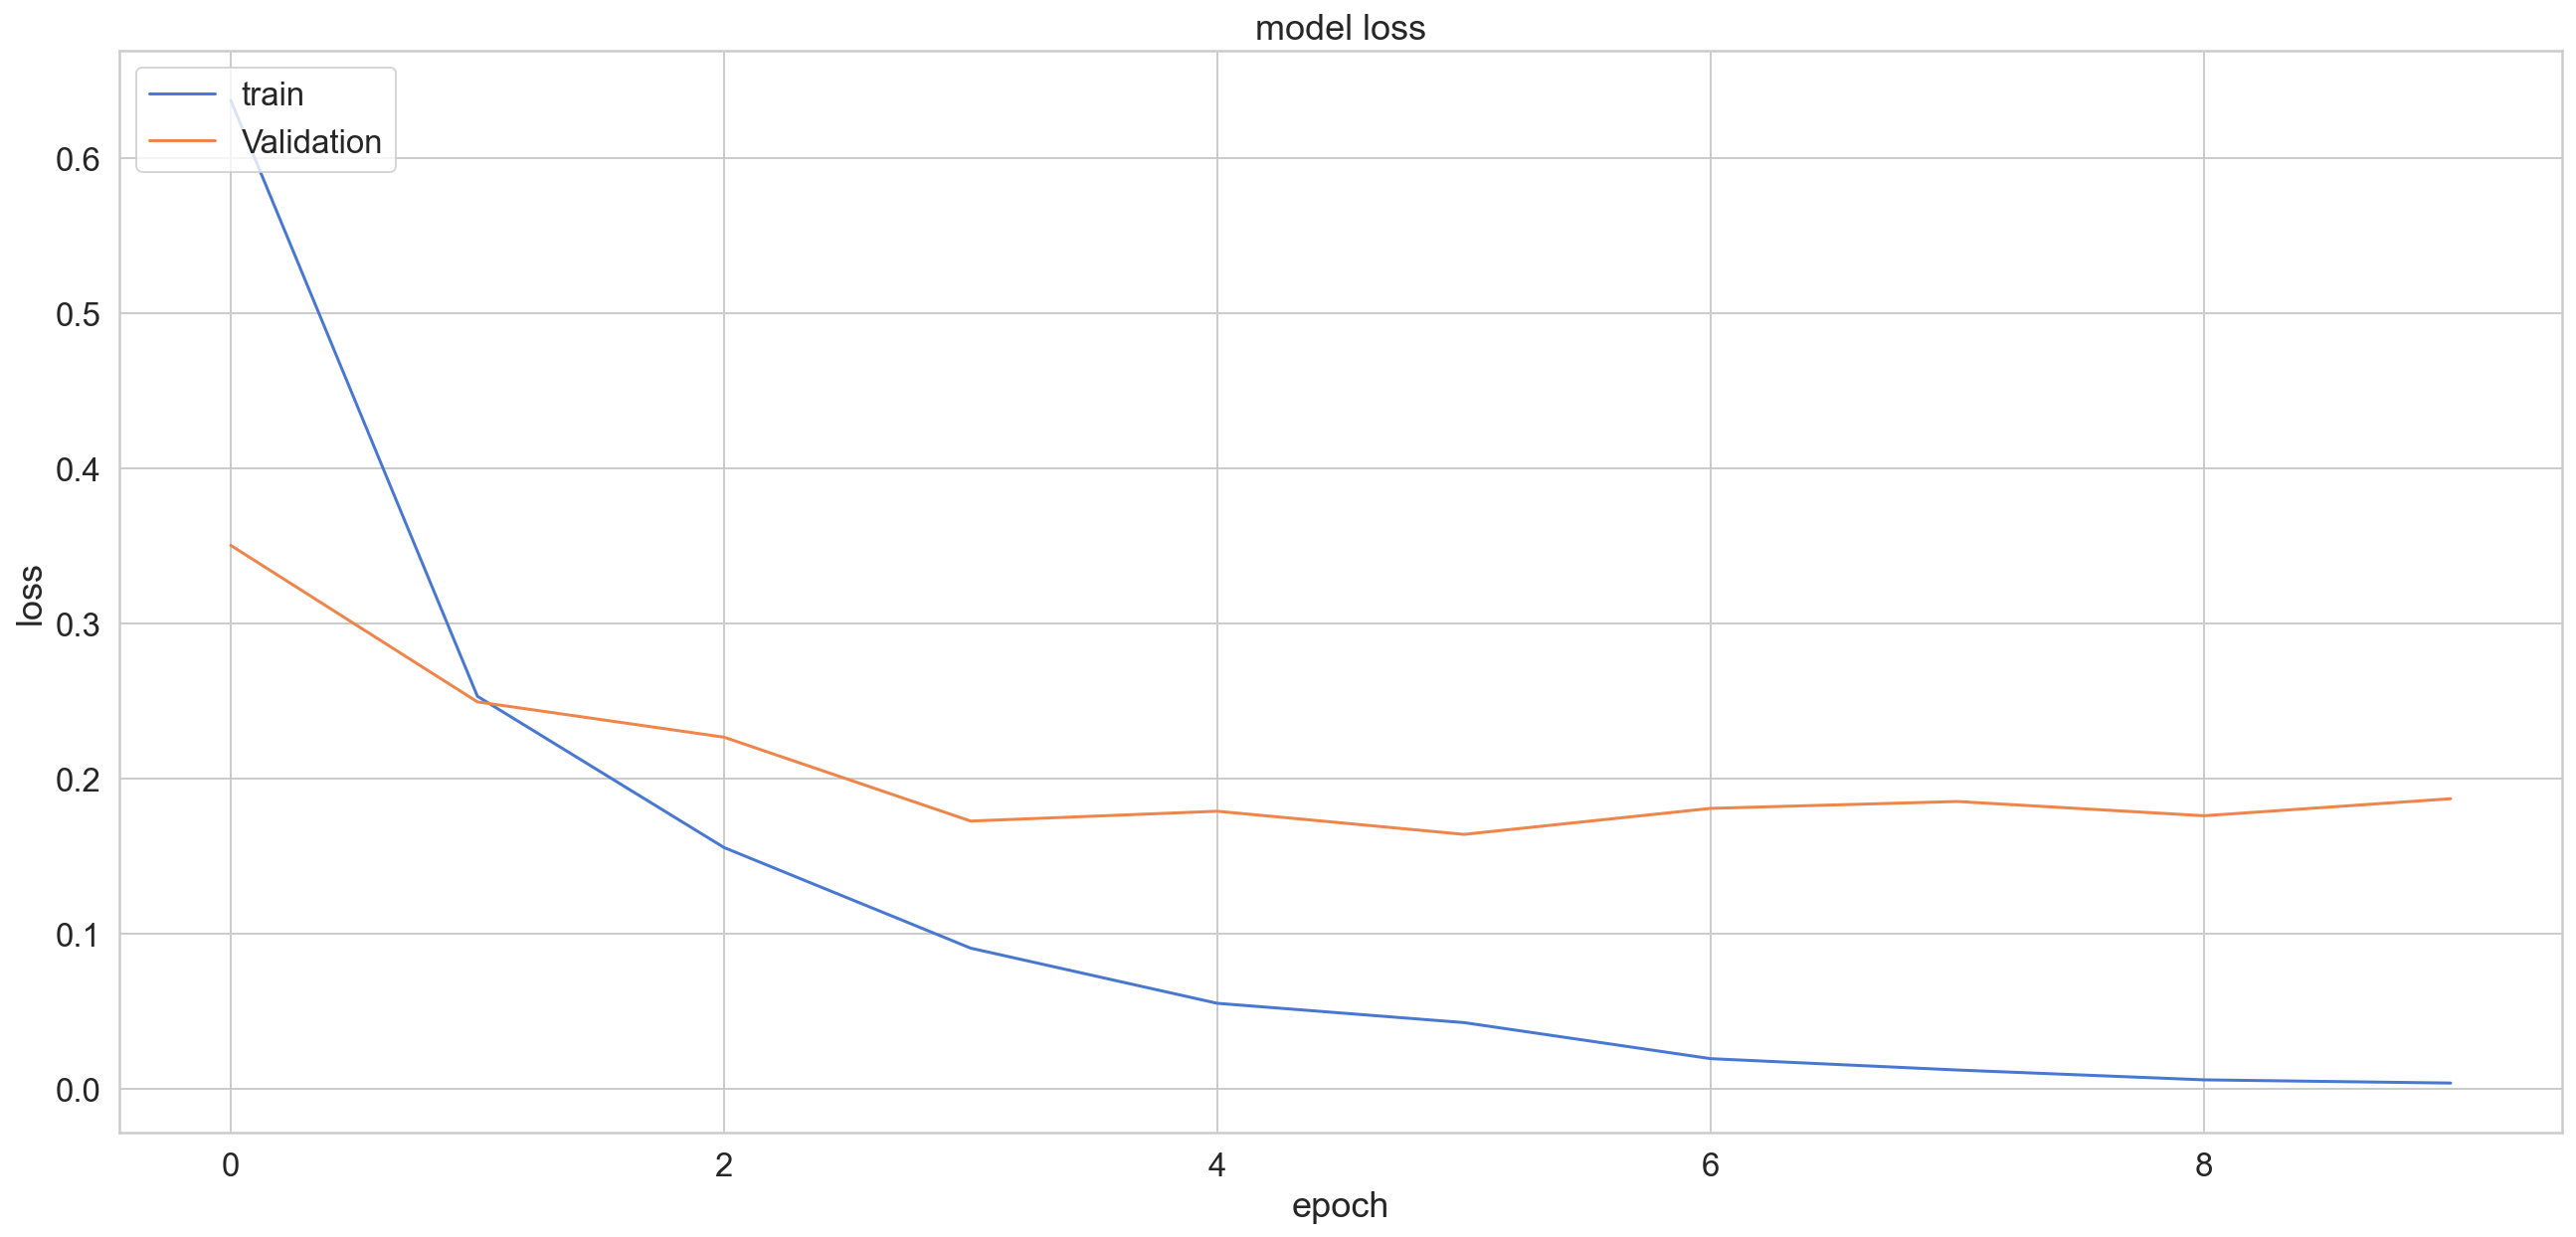

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

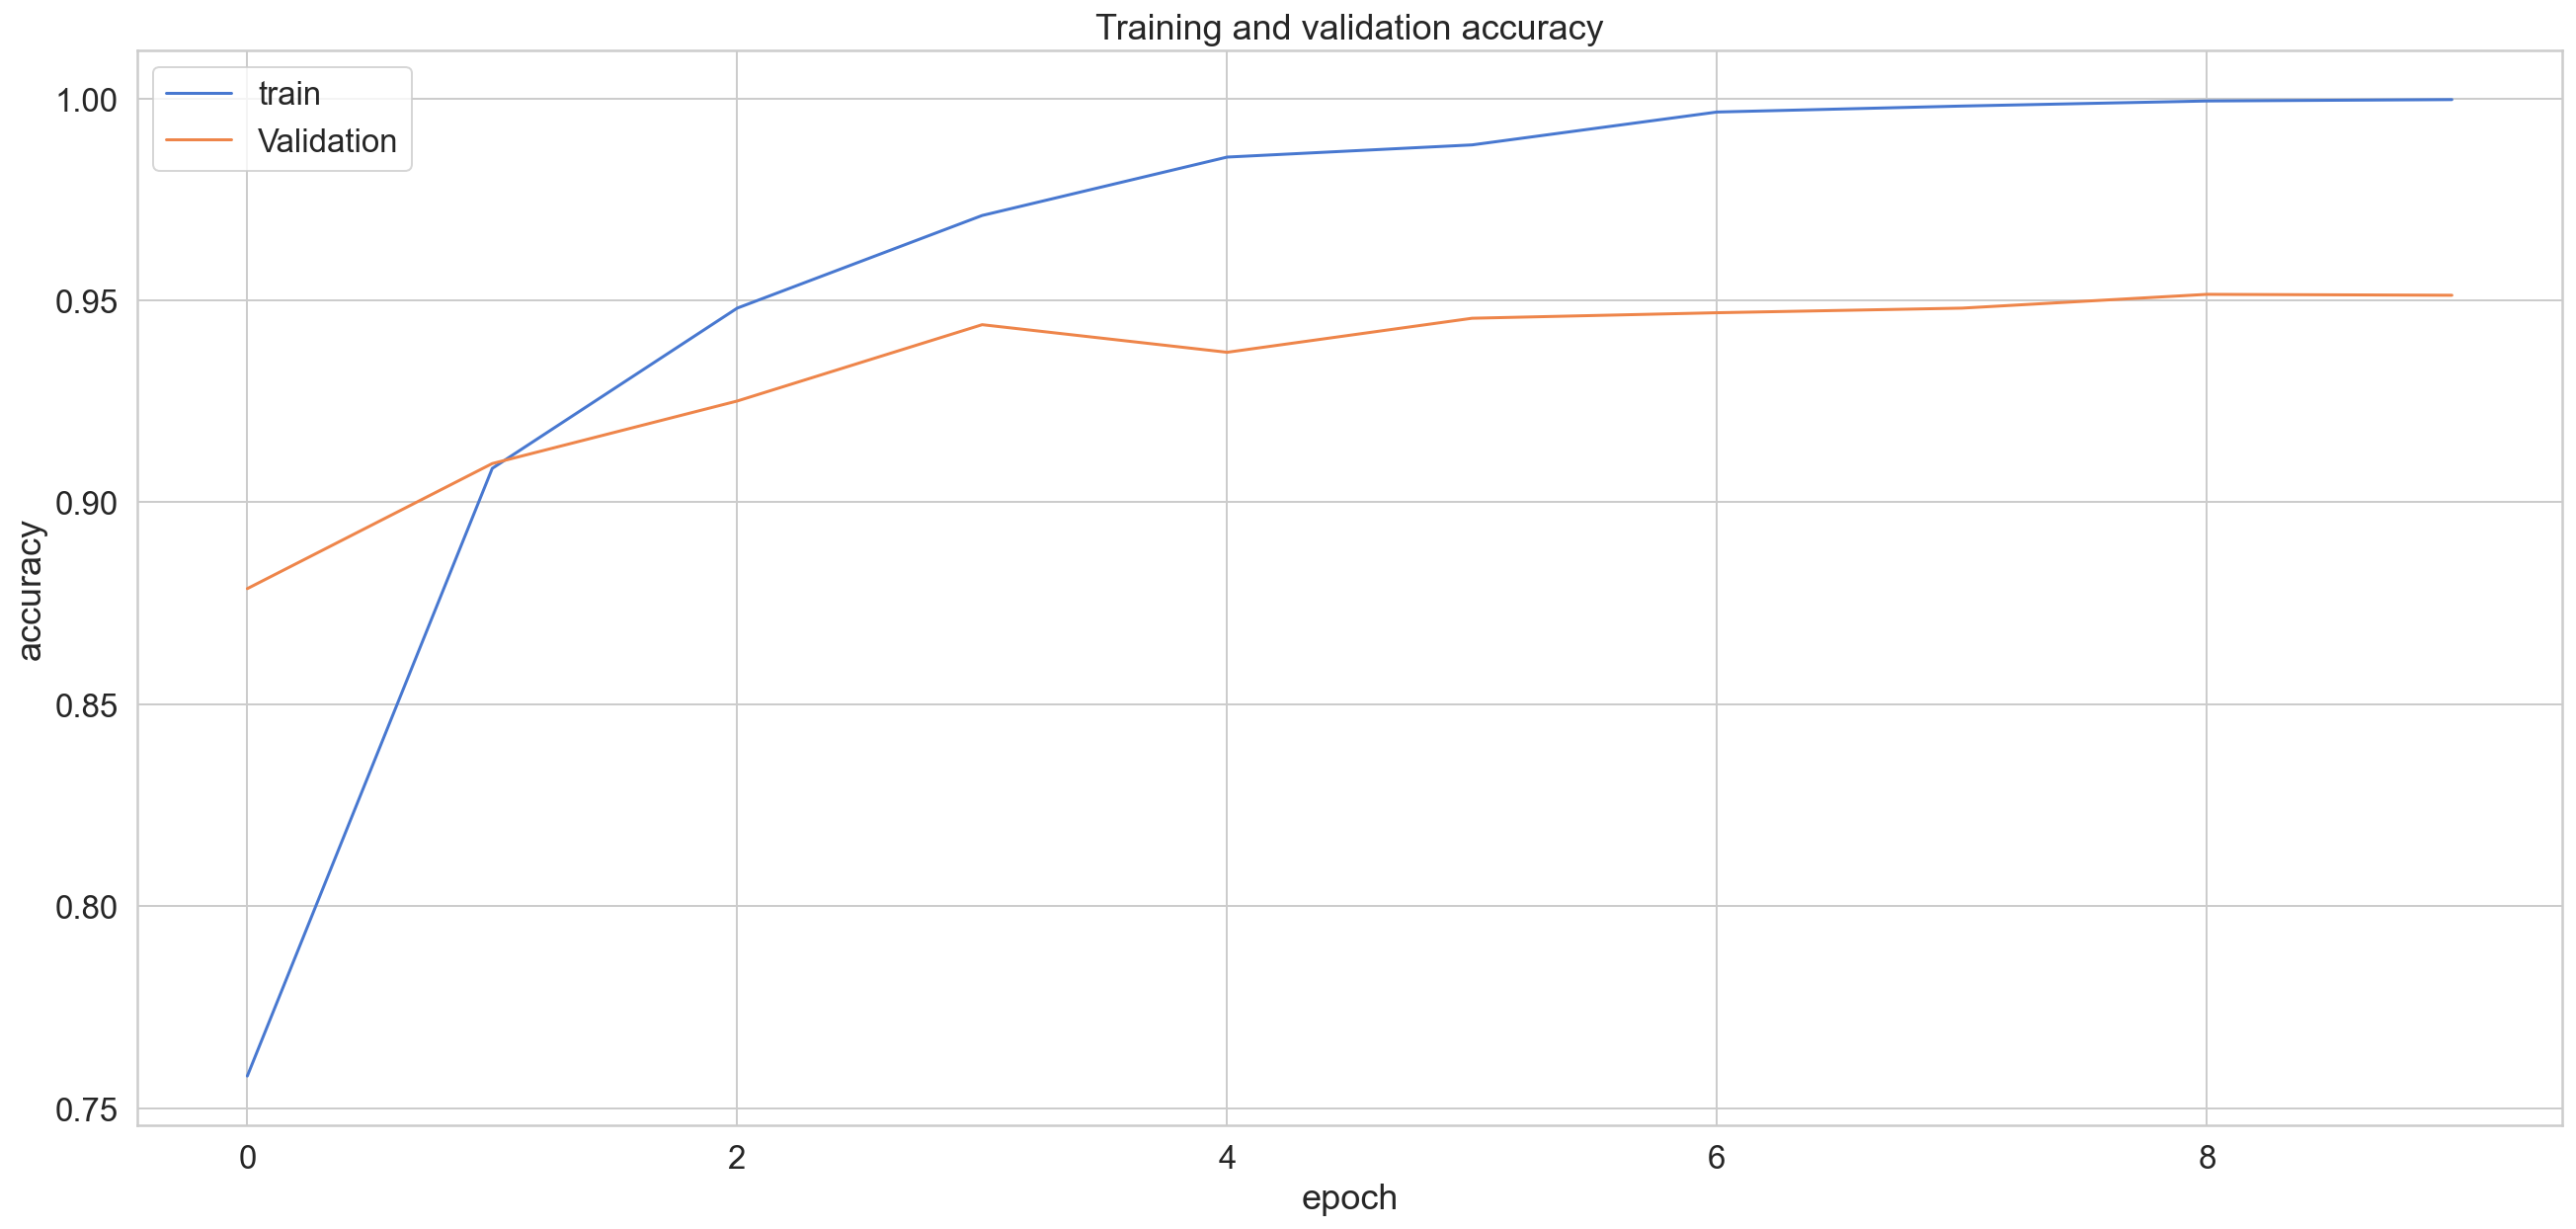

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

f1_score =  0.9520732313674601
0.952467674376252
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2123
           1       0.98      0.99      0.98      1710
           2       0.91      0.78      0.84       614
           3       0.80      0.89      0.84       502
           4       1.00      0.98      0.99       300
           5       0.98      0.98      0.98       242

    accuracy                           0.95      5491
   macro avg       0.94      0.93      0.94      5491
weighted avg       0.95      0.95      0.95      5491



<AxesSubplot:>

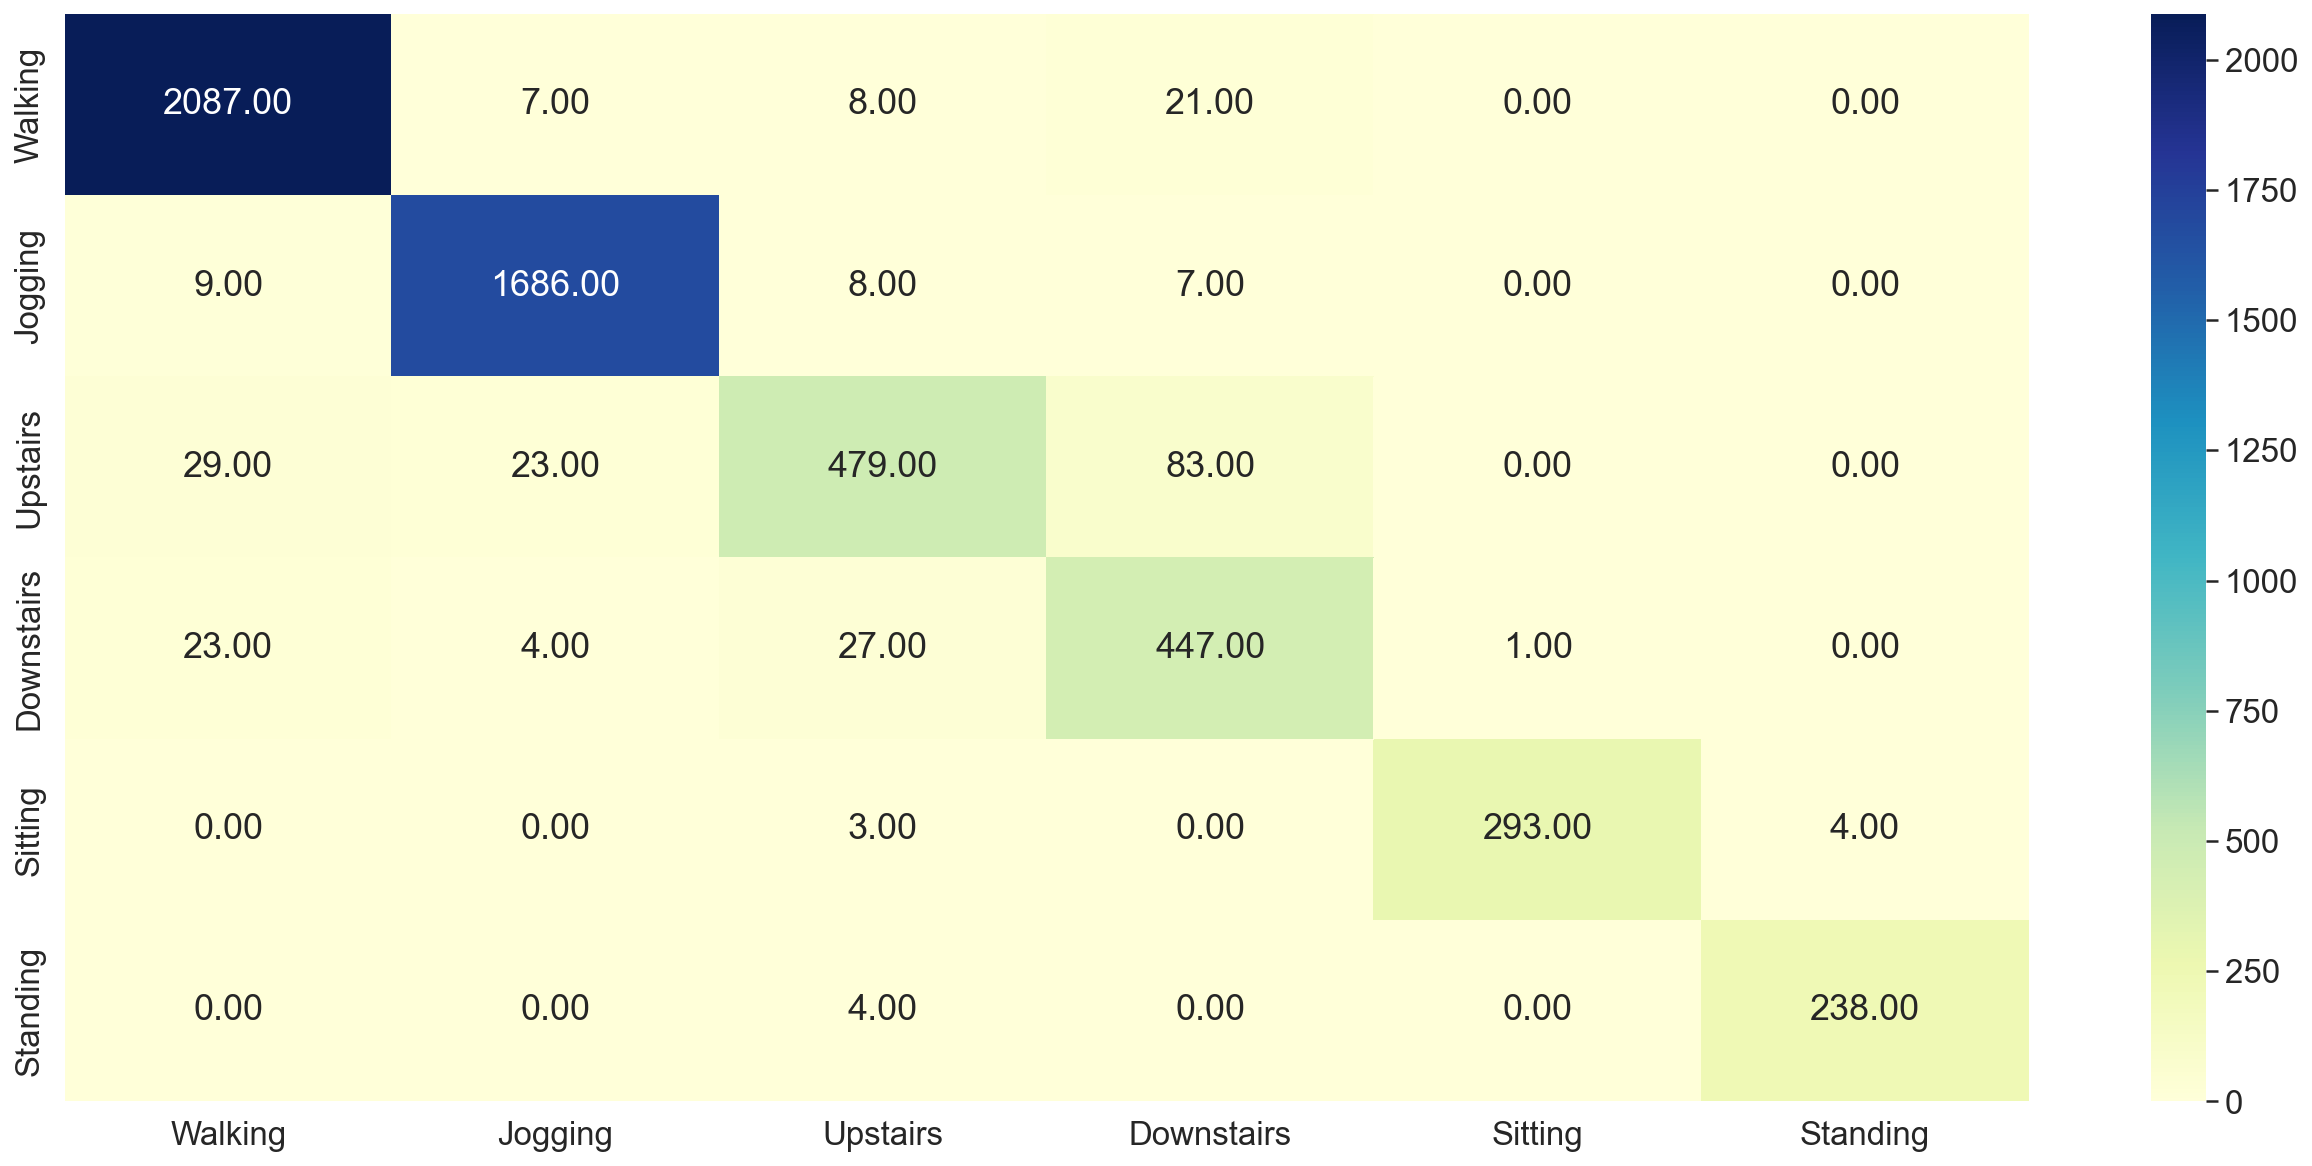

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN3</h1>

In [25]:
# Model 3
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 198, 64)           640       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 196, 64)           12352     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 194, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 97, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6208)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               794752    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
138/138 [==============================] - 13s 88ms/step - loss: 0.5908 - accuracy: 0.7728 - val_loss: 0.3114 - val_accuracy: 0.8800
Epoch 2/10
138/138 [==============================] - 12s 85ms/step - loss: 0.2268 - accuracy: 0.9162 - val_loss: 0.2026 - val_accuracy: 0.9285
Epoch 3/10
138/138 [==============================] - 12s 86ms/step - loss: 0.1342 - accuracy: 0.9553 - val_loss: 0.1697 - val_accuracy: 0.9403
Epoch 4/10
138/138 [==============================] - 12s 86ms/step - loss: 0.0955 - accuracy: 0.9694 - val_loss: 0.1082 - val_accuracy: 0.9627
Epoch 5/10
138/138 [==============================] - 12s 86ms/step - loss: 0.0602 - accuracy: 0.9812 - val_loss: 0.0987 - val_accuracy: 0.9649
Epoch 6/10
138/138 [==============================] - 12s 86ms/step - loss: 0.0425 - accuracy: 0.9876 - val_loss: 0.0963 - val_accuracy: 0.9677
Epoch 7/10
138/138 [==============================] - 12s 86ms/step - loss: 0.0427 - accuracy: 0.9870 - val_loss: 0.0813 - val_accuracy:

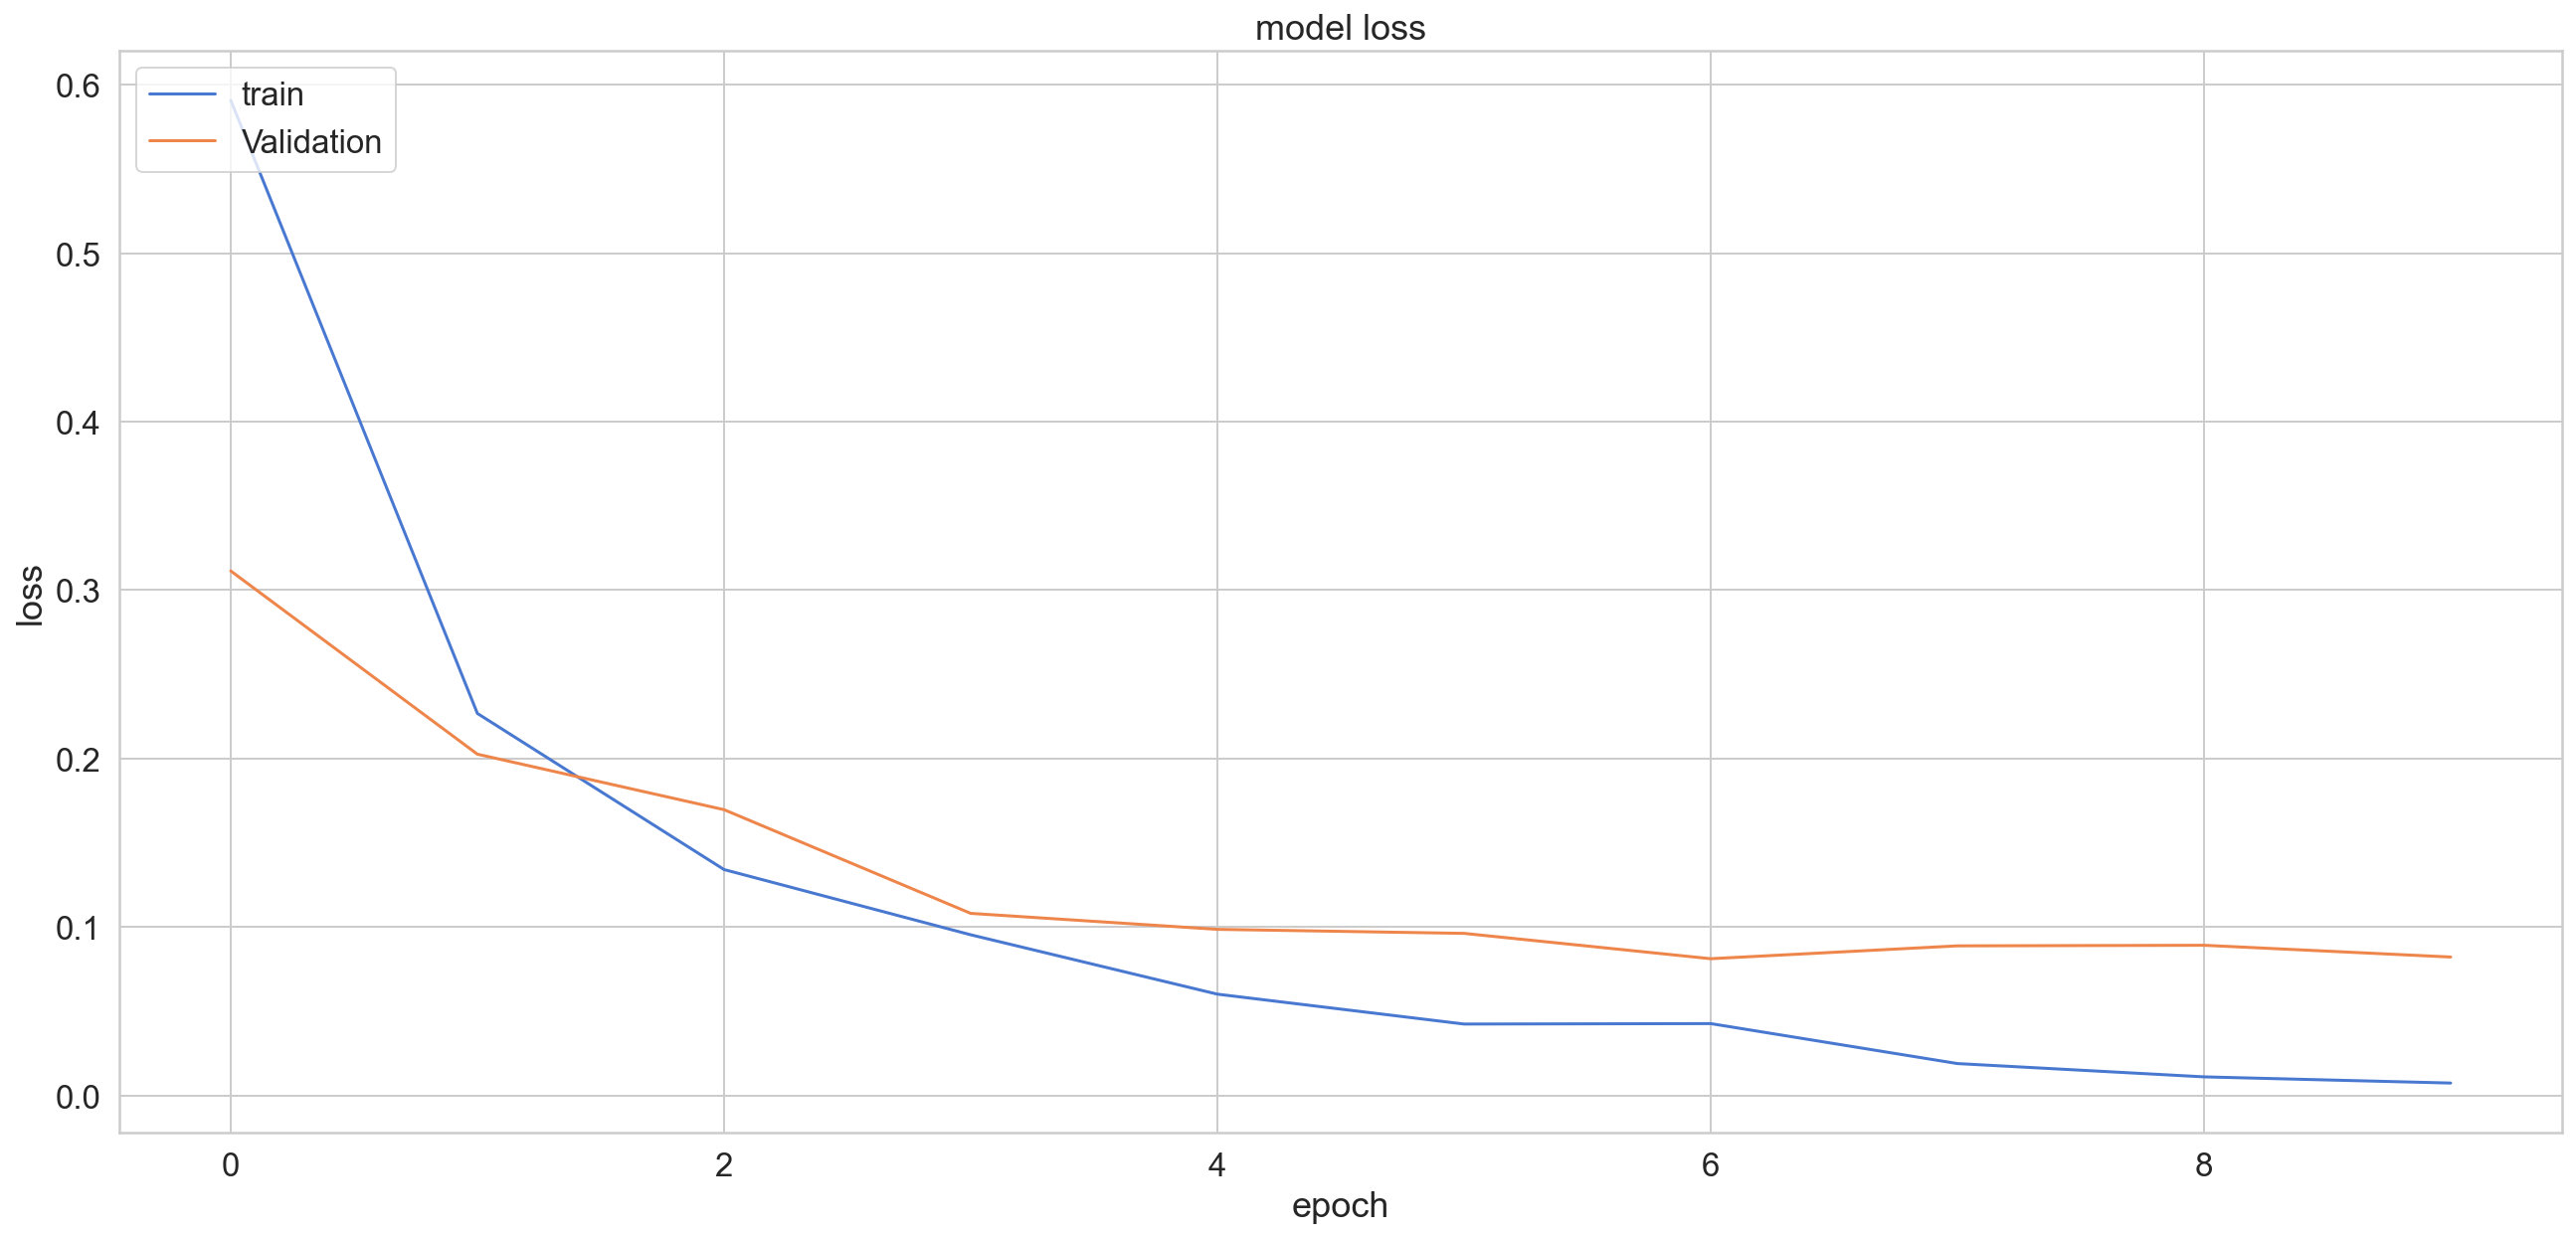

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

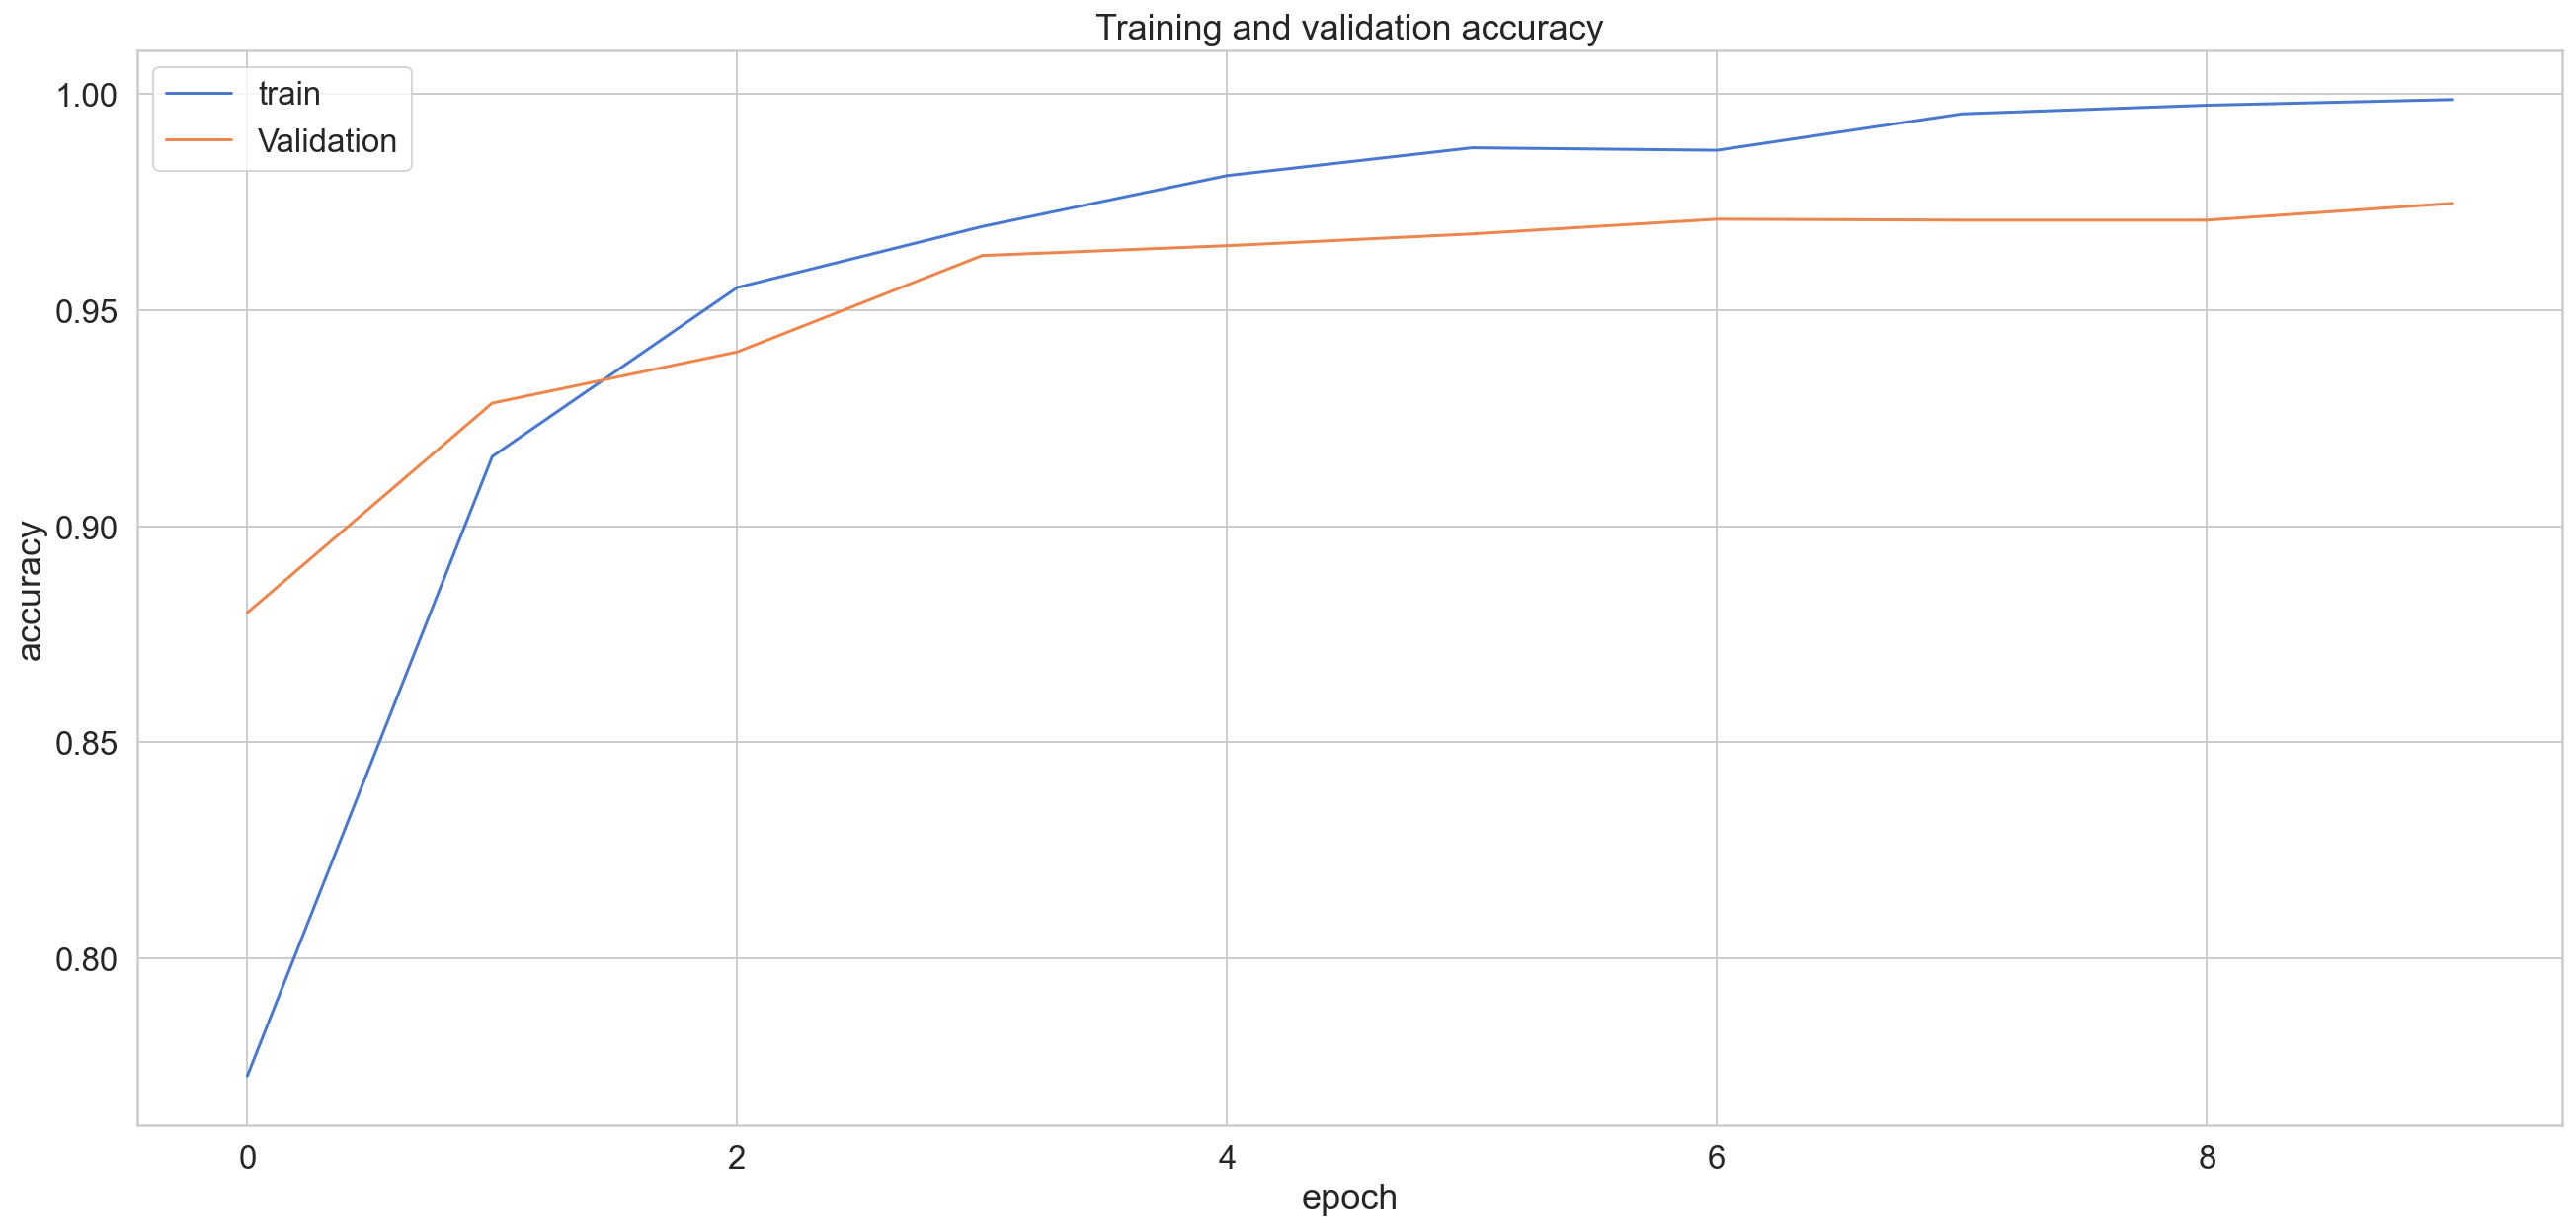

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

f1_score =  0.9749091590707046
0.9748679657621563
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.91      0.93      0.92       614
           3       0.92      0.90      0.91       502
           4       0.99      0.99      0.99       300
           5       0.98      0.99      0.99       242

    accuracy                           0.97      5491
   macro avg       0.96      0.96      0.96      5491
weighted avg       0.98      0.97      0.97      5491



<AxesSubplot:>

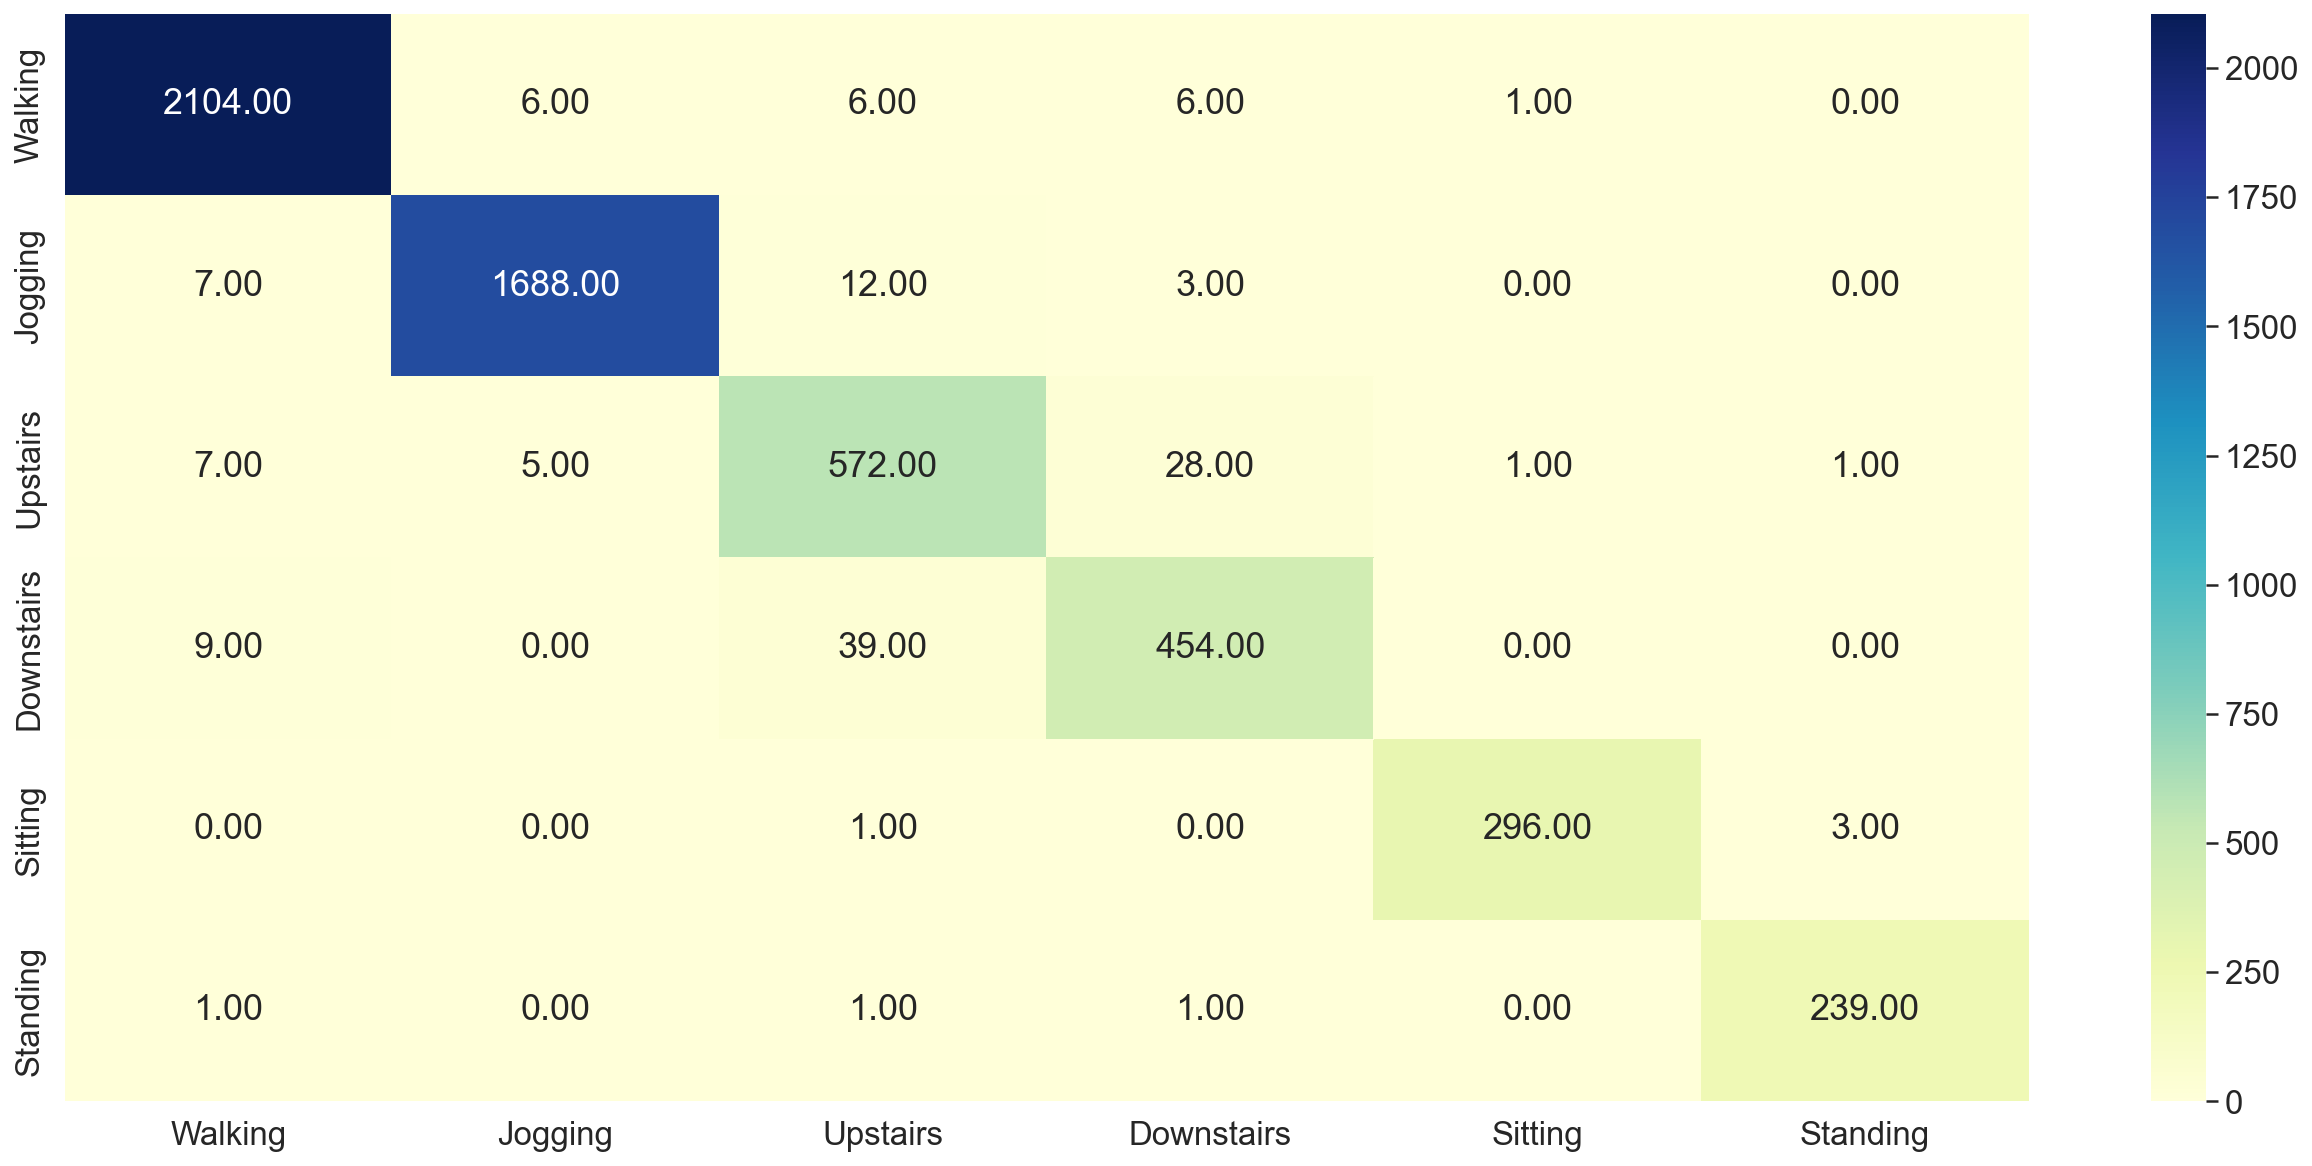

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 4</h1>

In [30]:
# Model 4
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 198, 64)           640       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 196, 64)           12352     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 194, 64)           12352     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 192, 64)           12352     
_________________________________________________________________
flatten_3 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1572992   
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
138/138 [==============================] - 17s 116ms/step - loss: 0.5524 - accuracy: 0.7877 - val_loss: 0.2890 - val_accuracy: 0.8925
Epoch 2/10
138/138 [==============================] - 16s 114ms/step - loss: 0.2008 - accuracy: 0.9299 - val_loss: 0.1706 - val_accuracy: 0.9435
Epoch 3/10
138/138 [==============================] - 16s 113ms/step - loss: 0.1102 - accuracy: 0.9644 - val_loss: 0.1308 - val_accuracy: 0.9545
Epoch 4/10
138/138 [==============================] - 16s 114ms/step - loss: 0.0671 - accuracy: 0.9774 - val_loss: 0.1129 - val_accuracy: 0.9624
Epoch 5/10
138/138 [==============================] - 16s 114ms/step - loss: 0.0423 - accuracy: 0.9872 - val_loss: 0.1990 - val_accuracy: 0.9531
Epoch 6/10
138/138 [==============================] - 16s 113ms/step - loss: 0.0353 - accuracy: 0.9892 - val_loss: 0.0912 - val_accuracy: 0.9672
Epoch 7/10
138/138 [==============================] - 16s 114ms/step - loss: 0.0352 - accuracy: 0.9887 - val_loss: 0.0991 - val_ac

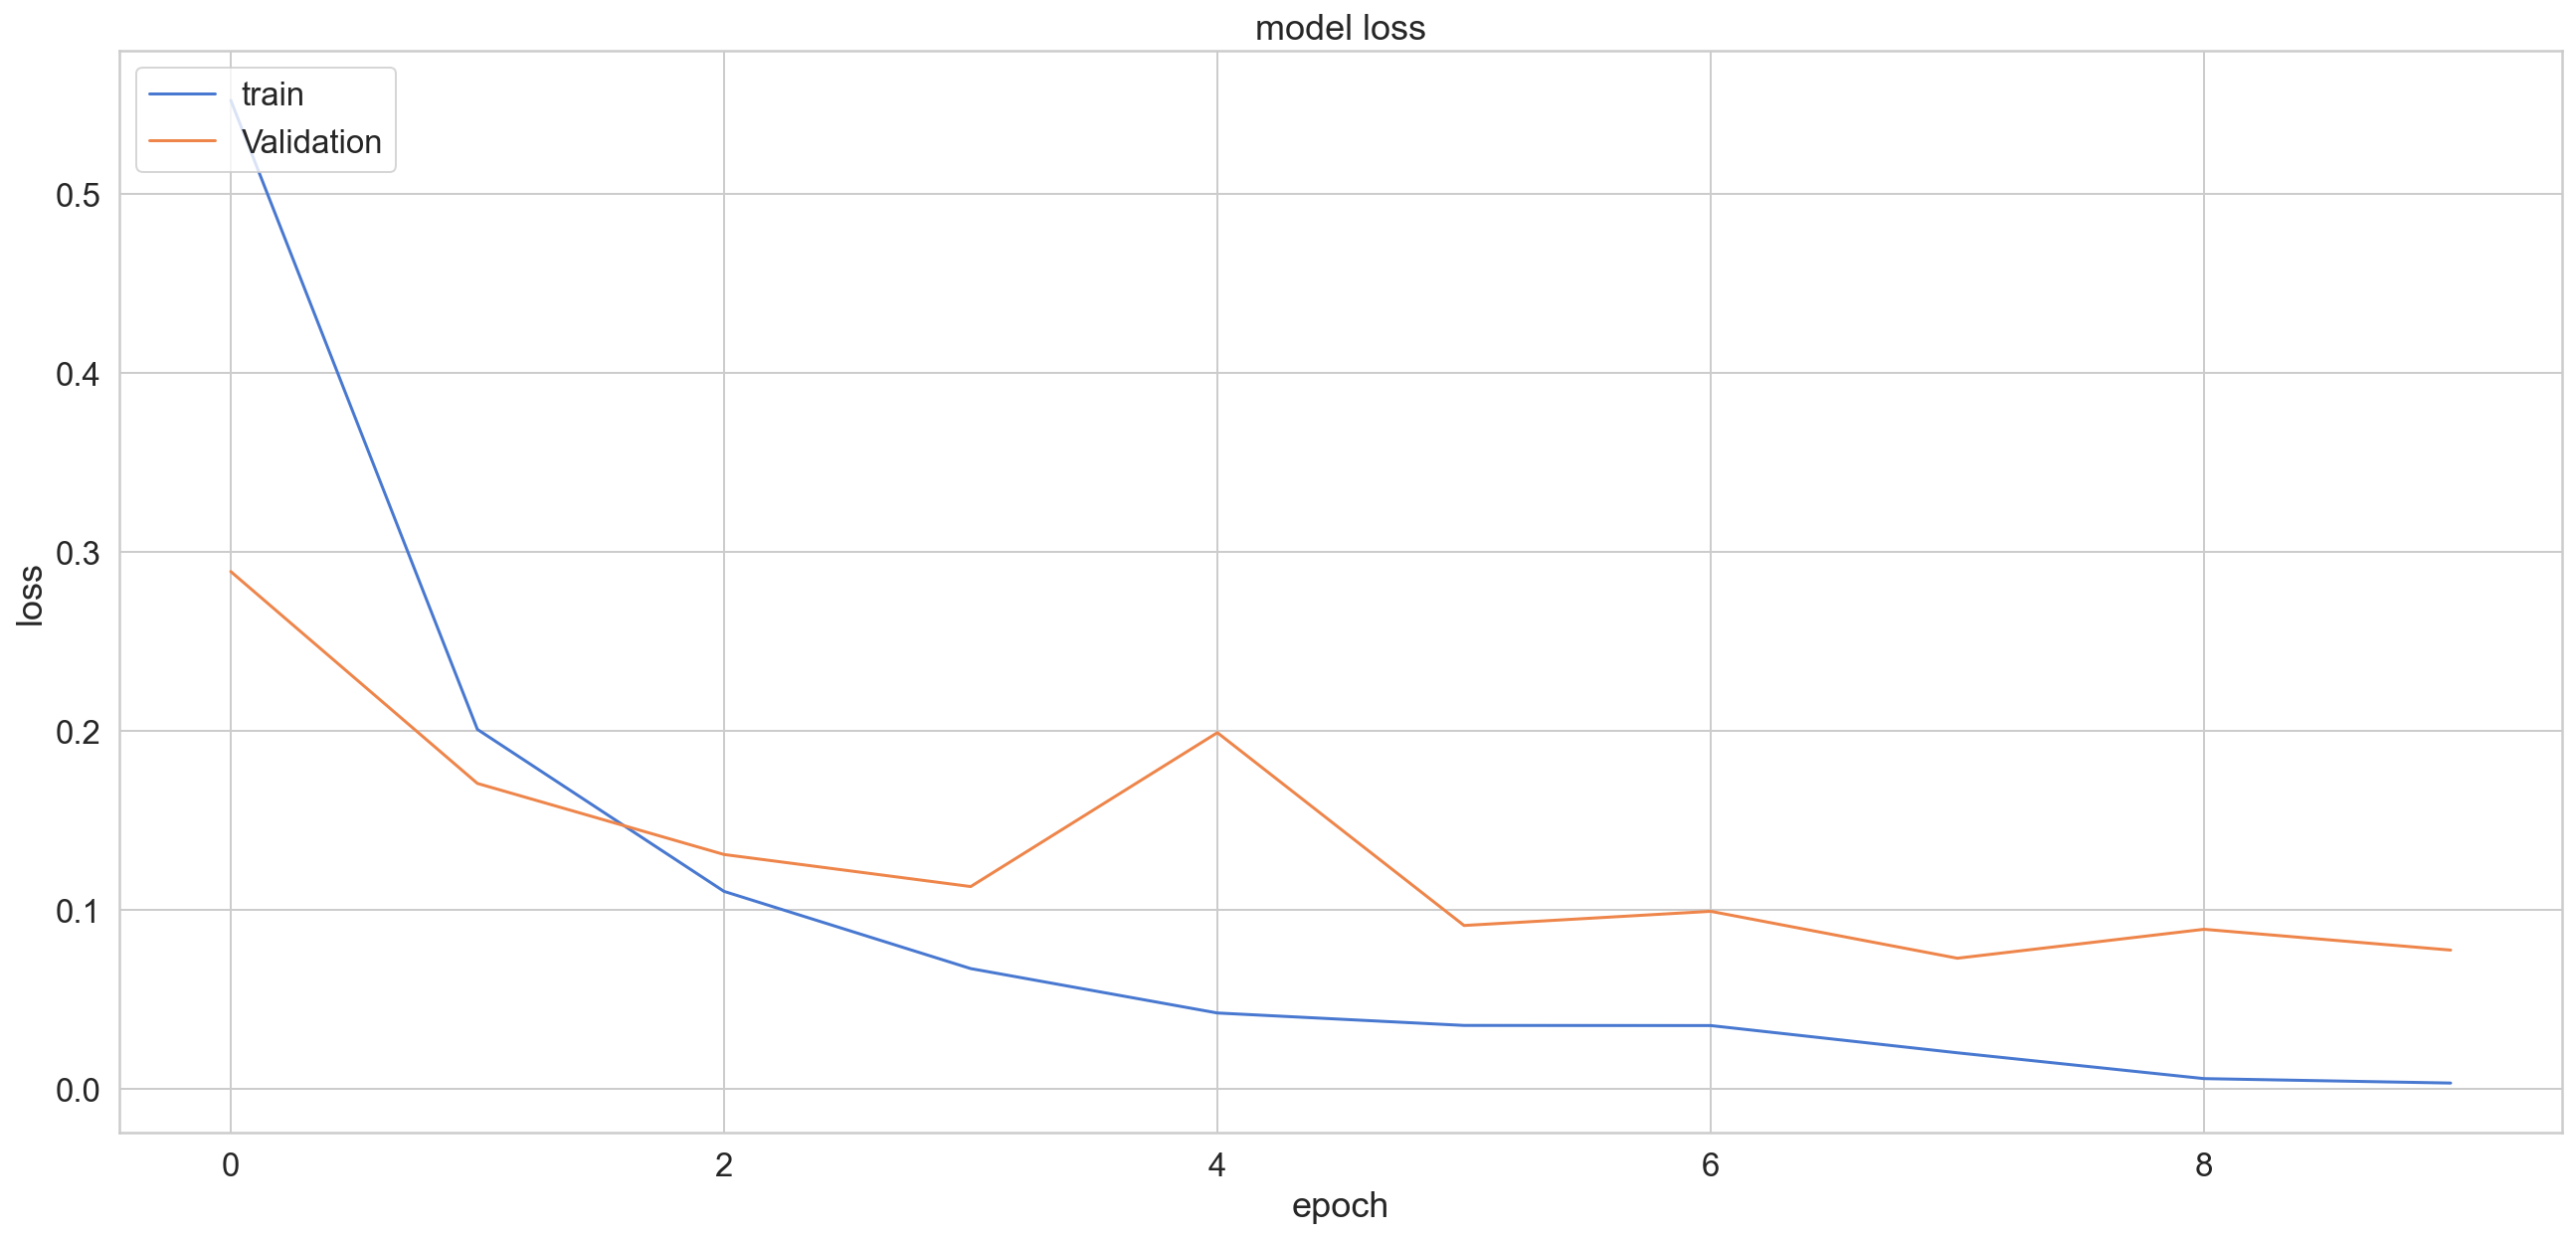

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

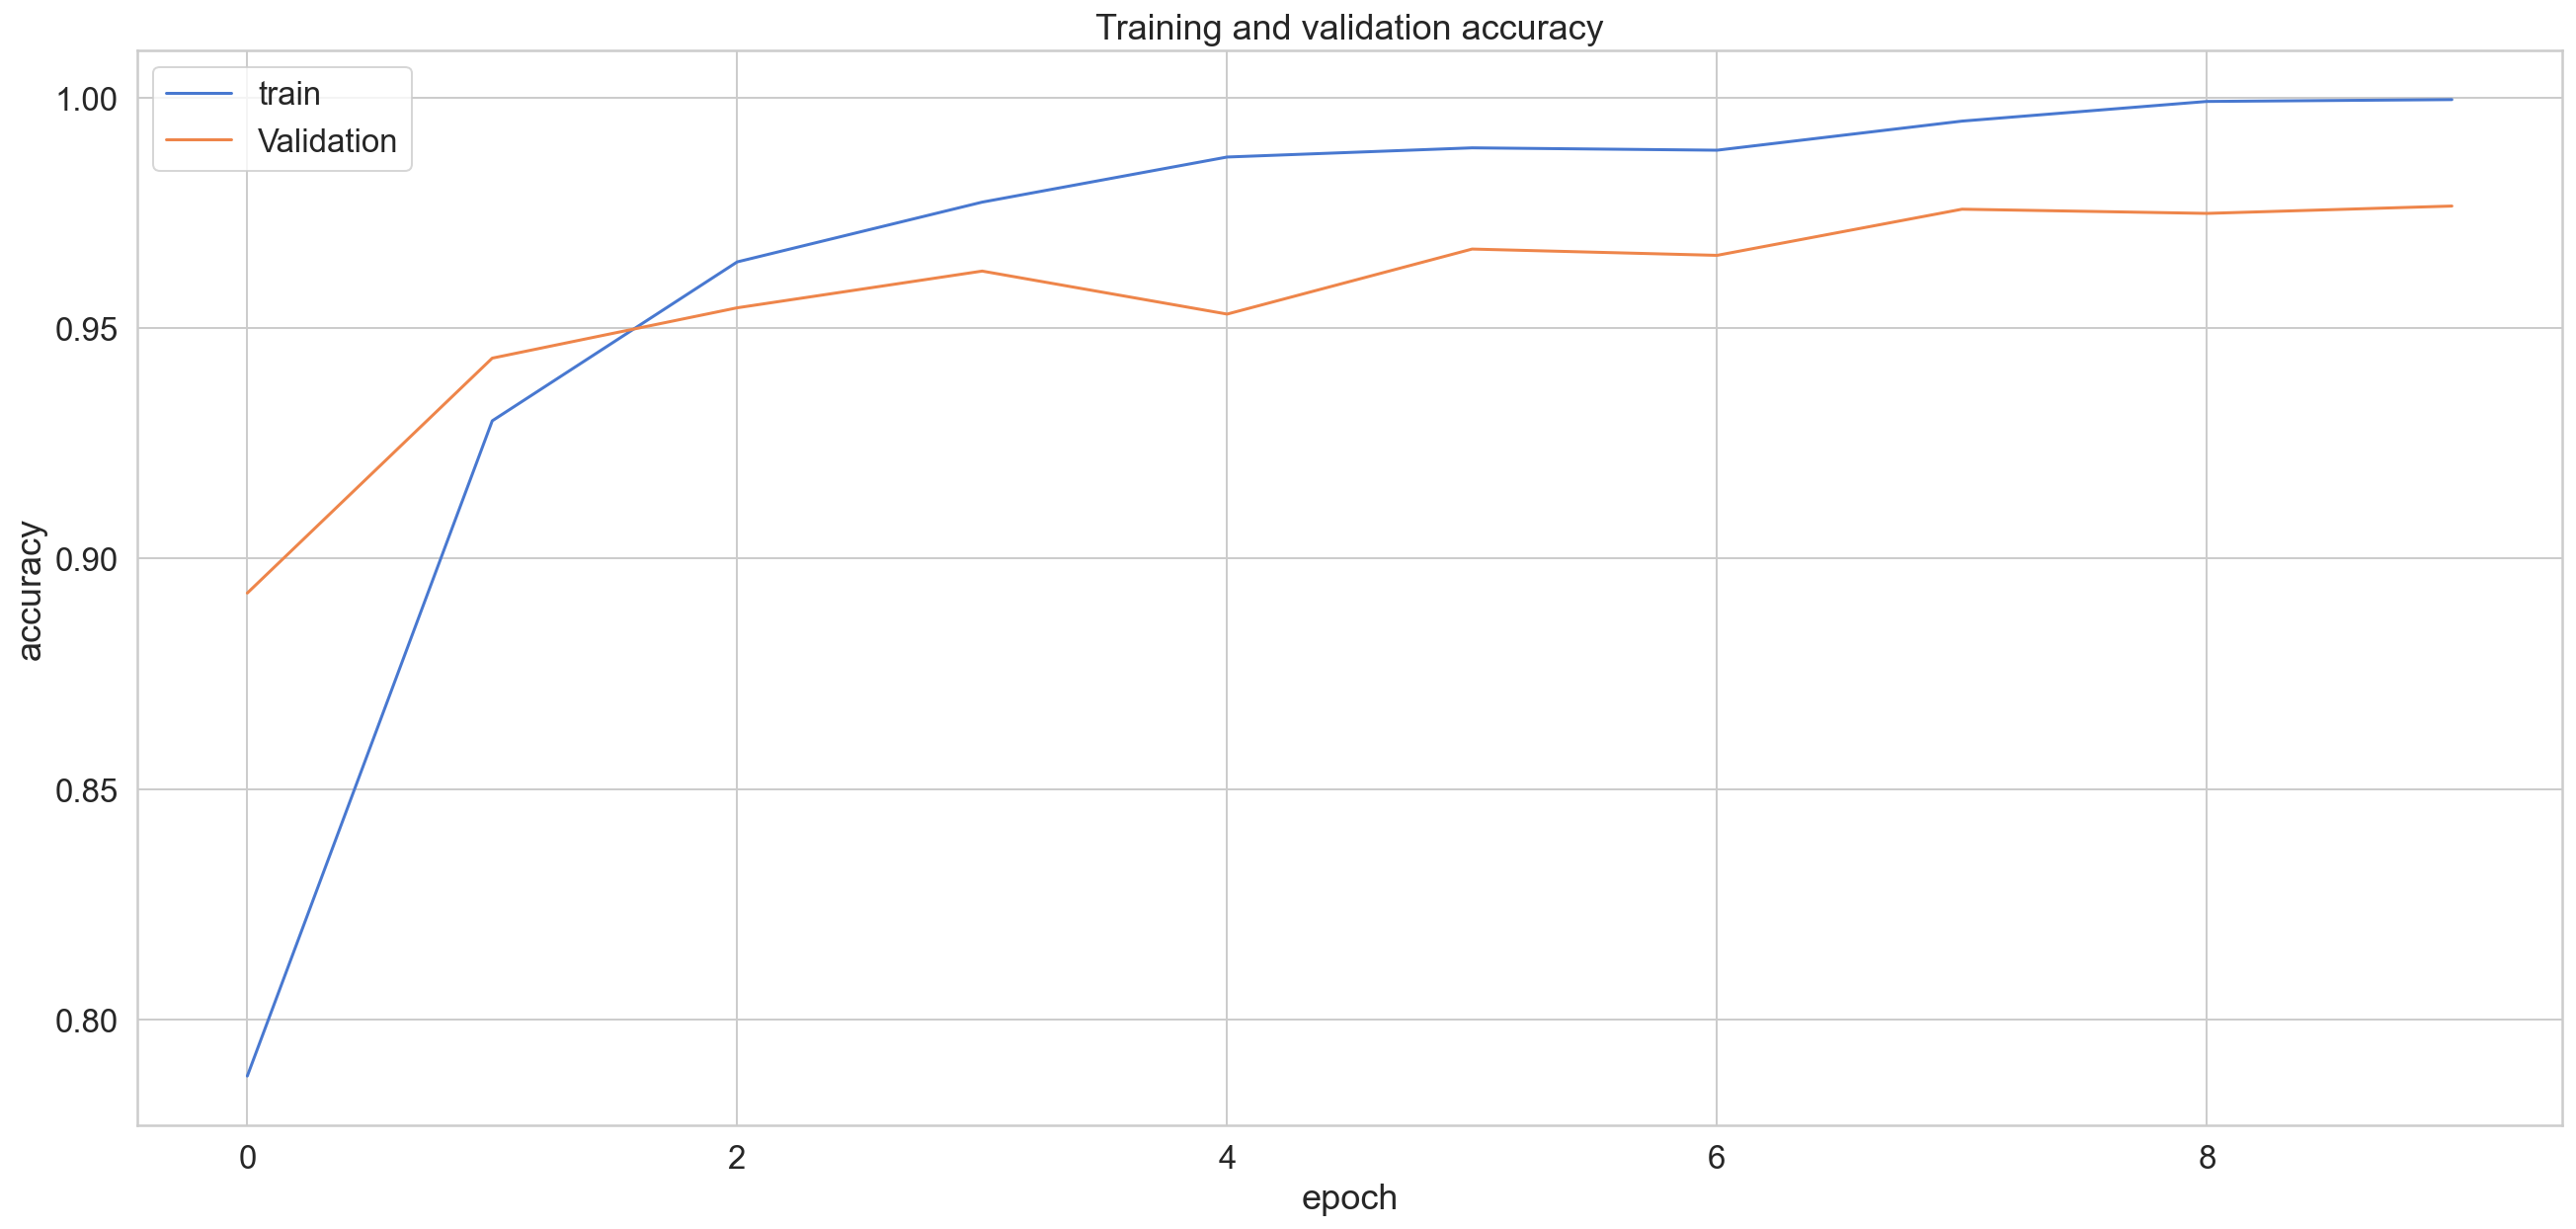

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

f1_score =  0.9799397705931387
0.9799672190857768
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.93      0.94      0.93       614
           3       0.93      0.92      0.93       502
           4       0.99      0.99      0.99       300
           5       0.99      0.99      0.99       242

    accuracy                           0.98      5491
   macro avg       0.97      0.97      0.97      5491
weighted avg       0.98      0.98      0.98      5491



<AxesSubplot:>

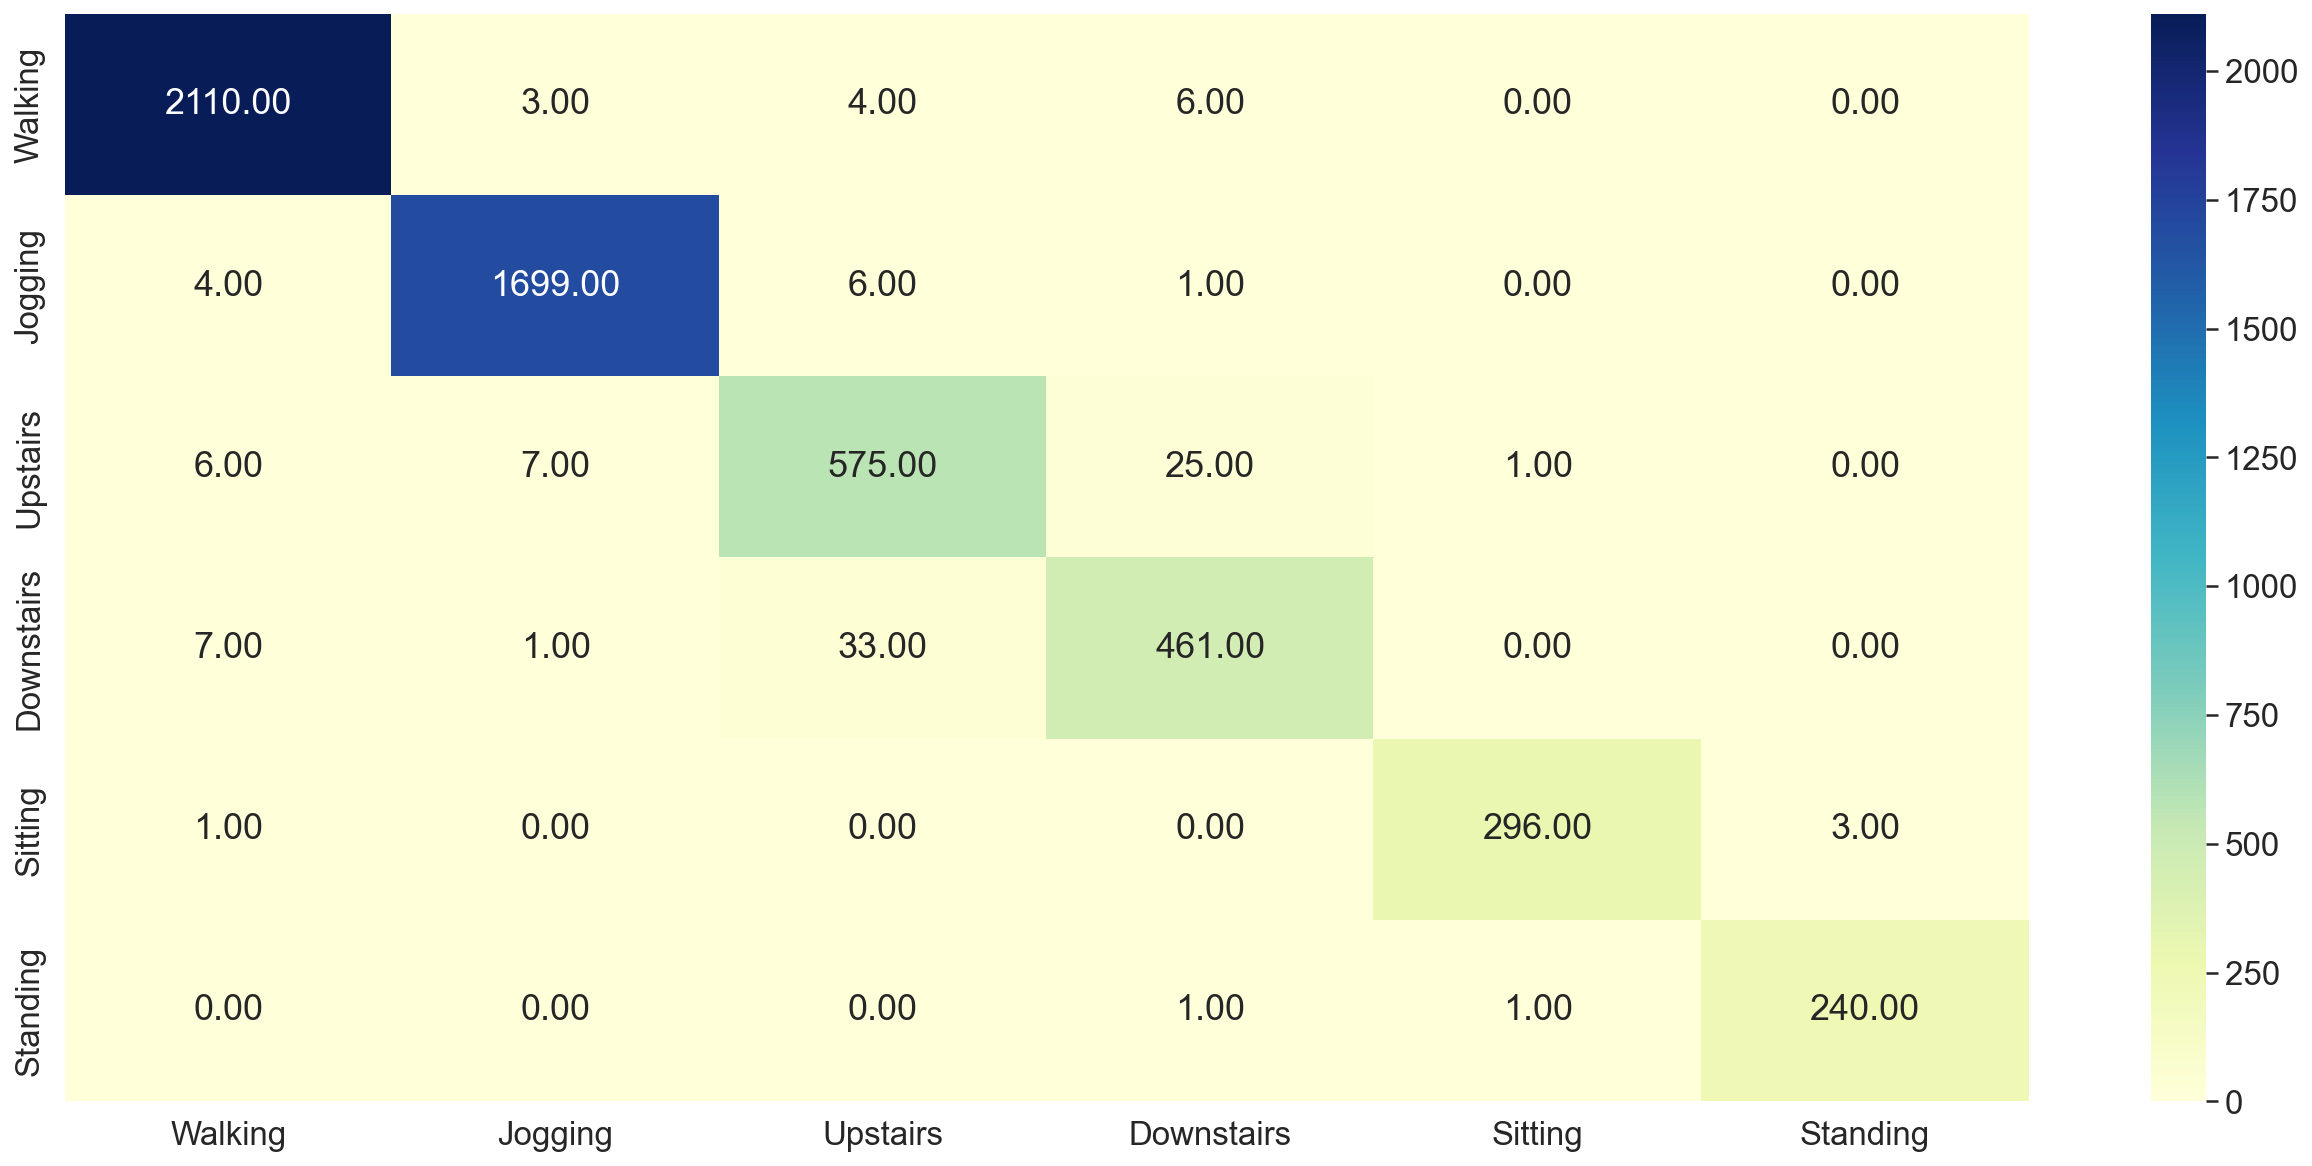

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>CNN 5</h5>

In [35]:
# Model 5
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

#model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 198, 64)           640       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 196, 64)           12352     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 194, 64)           12352     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 192, 64)           12352     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 190, 64)           12352     
_________________________________________________________________
flatten_4 (Flatten)          (None, 12160)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [36]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
138/138 [==============================] - 21s 144ms/step - loss: 0.5749 - accuracy: 0.7879 - val_loss: 0.3098 - val_accuracy: 0.8898
Epoch 2/10
138/138 [==============================] - 20s 142ms/step - loss: 0.1923 - accuracy: 0.9341 - val_loss: 0.1751 - val_accuracy: 0.9340
Epoch 3/10
138/138 [==============================] - 20s 142ms/step - loss: 0.1121 - accuracy: 0.9632 - val_loss: 0.1938 - val_accuracy: 0.9342
Epoch 4/10
138/138 [==============================] - 19s 141ms/step - loss: 0.0872 - accuracy: 0.9720 - val_loss: 0.0936 - val_accuracy: 0.9695
Epoch 5/10
138/138 [==============================] - 19s 141ms/step - loss: 0.0581 - accuracy: 0.9801 - val_loss: 0.1455 - val_accuracy: 0.9513
Epoch 6/10
138/138 [==============================] - 20s 142ms/step - loss: 0.0377 - accuracy: 0.9883 - val_loss: 0.0941 - val_accuracy: 0.9706
Epoch 7/10
138/138 [==============================] - 20s 142ms/step - loss: 0.0330 - accuracy: 0.9890 - val_loss: 0.0825 - val_ac

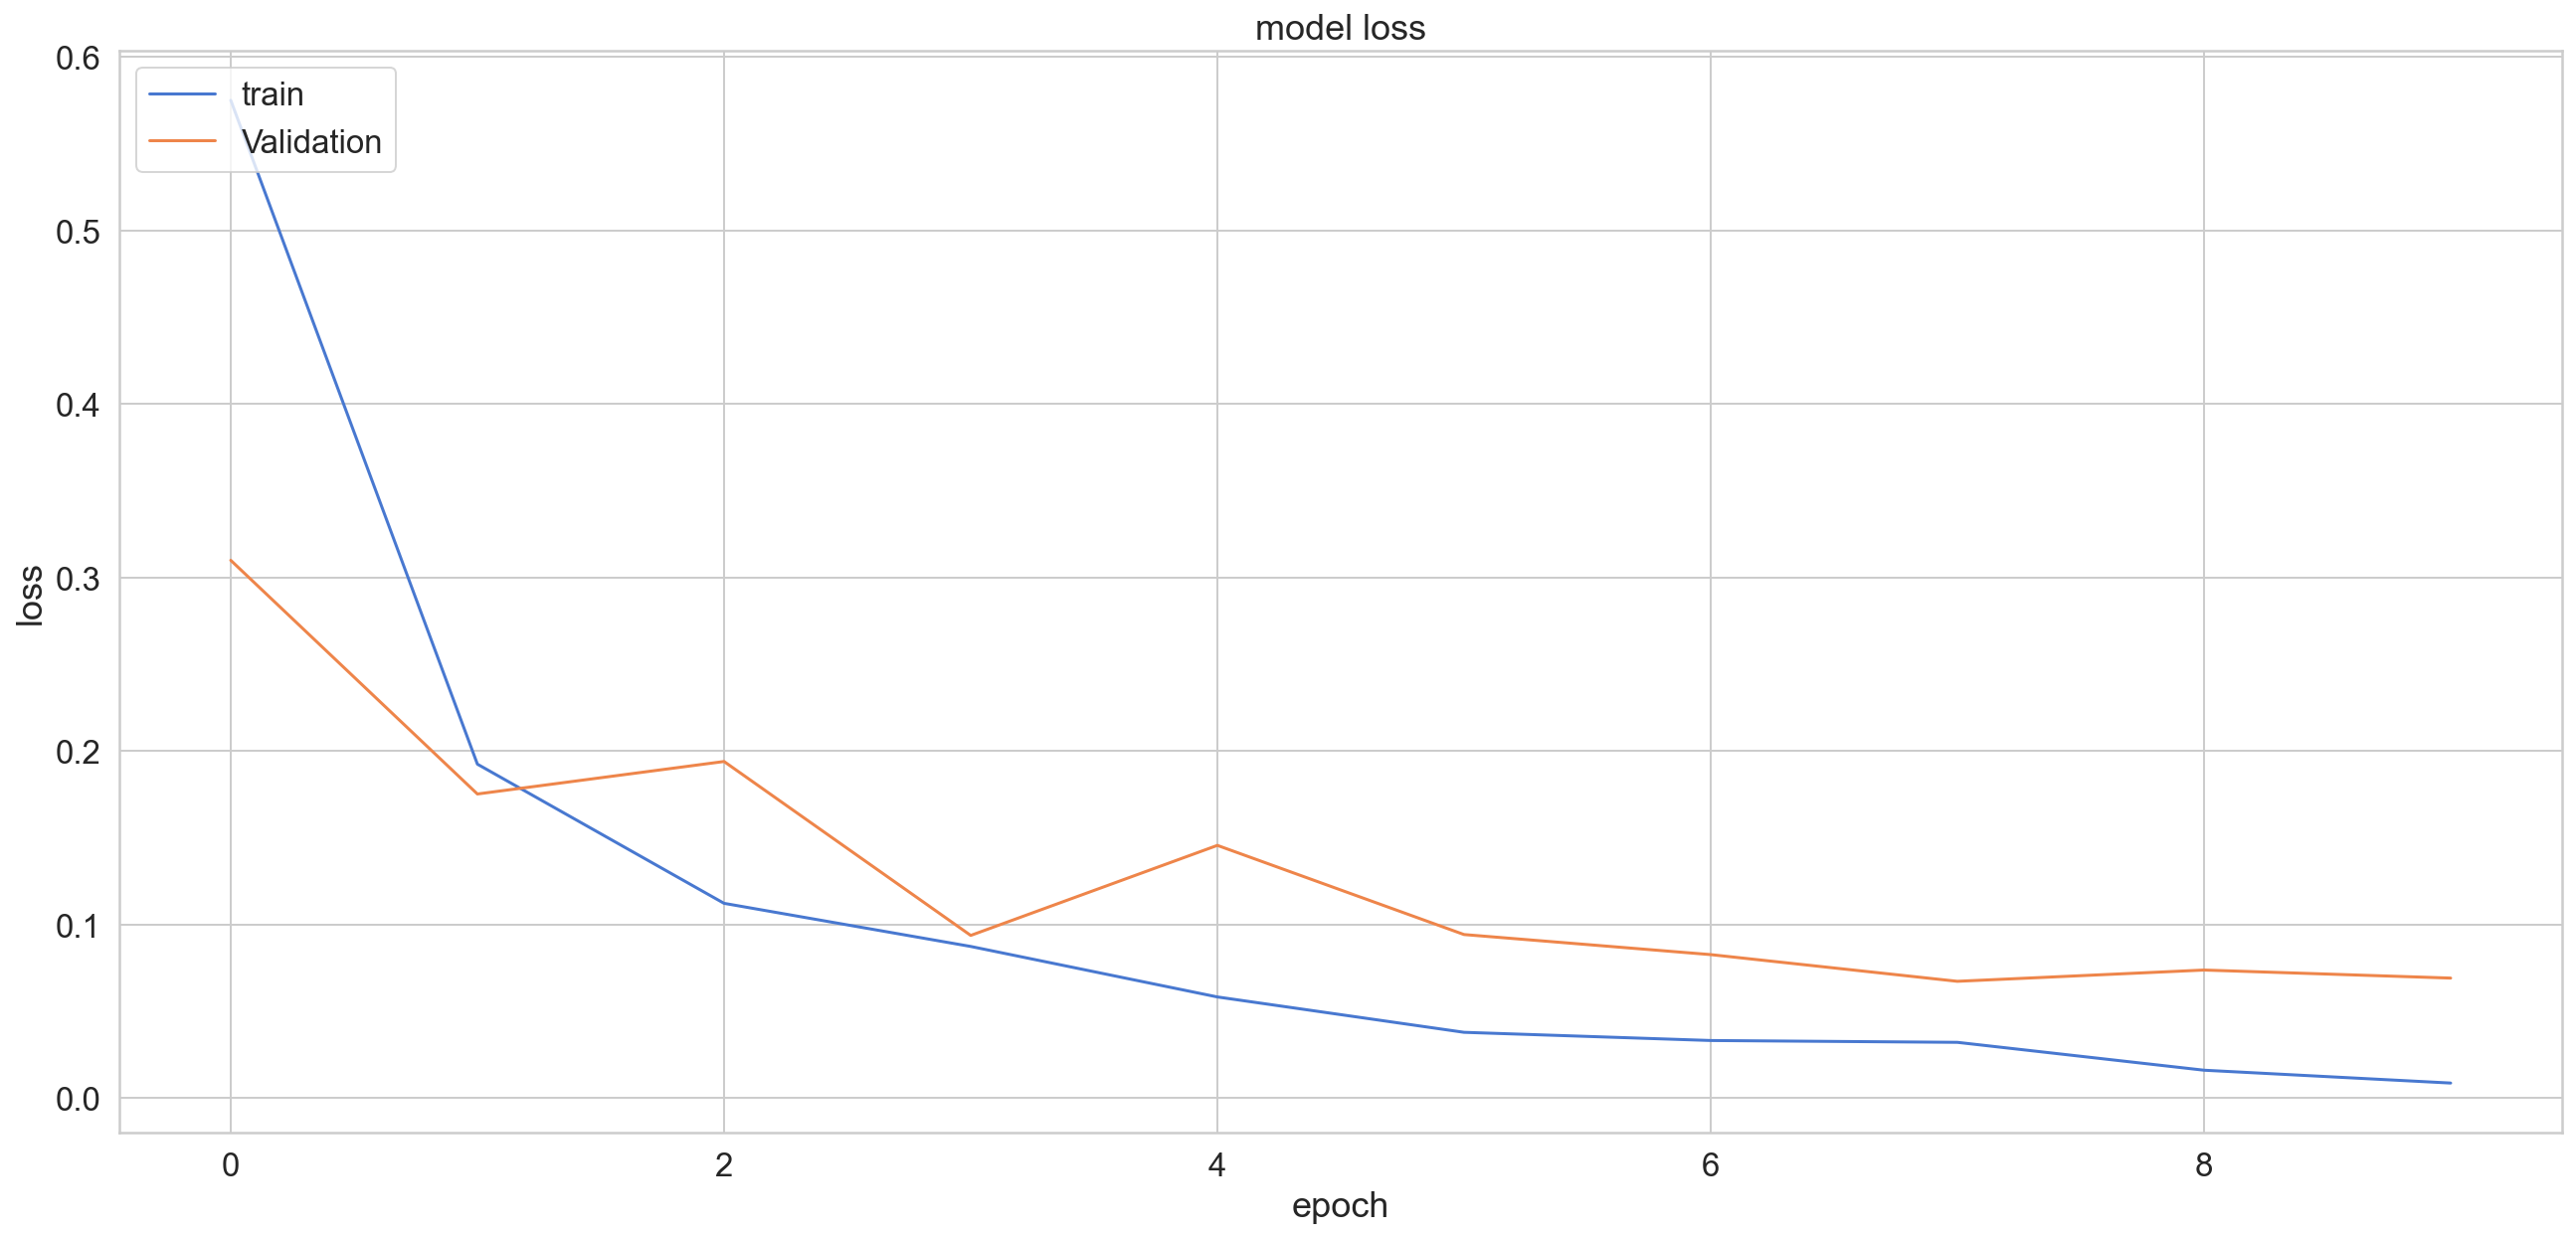

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

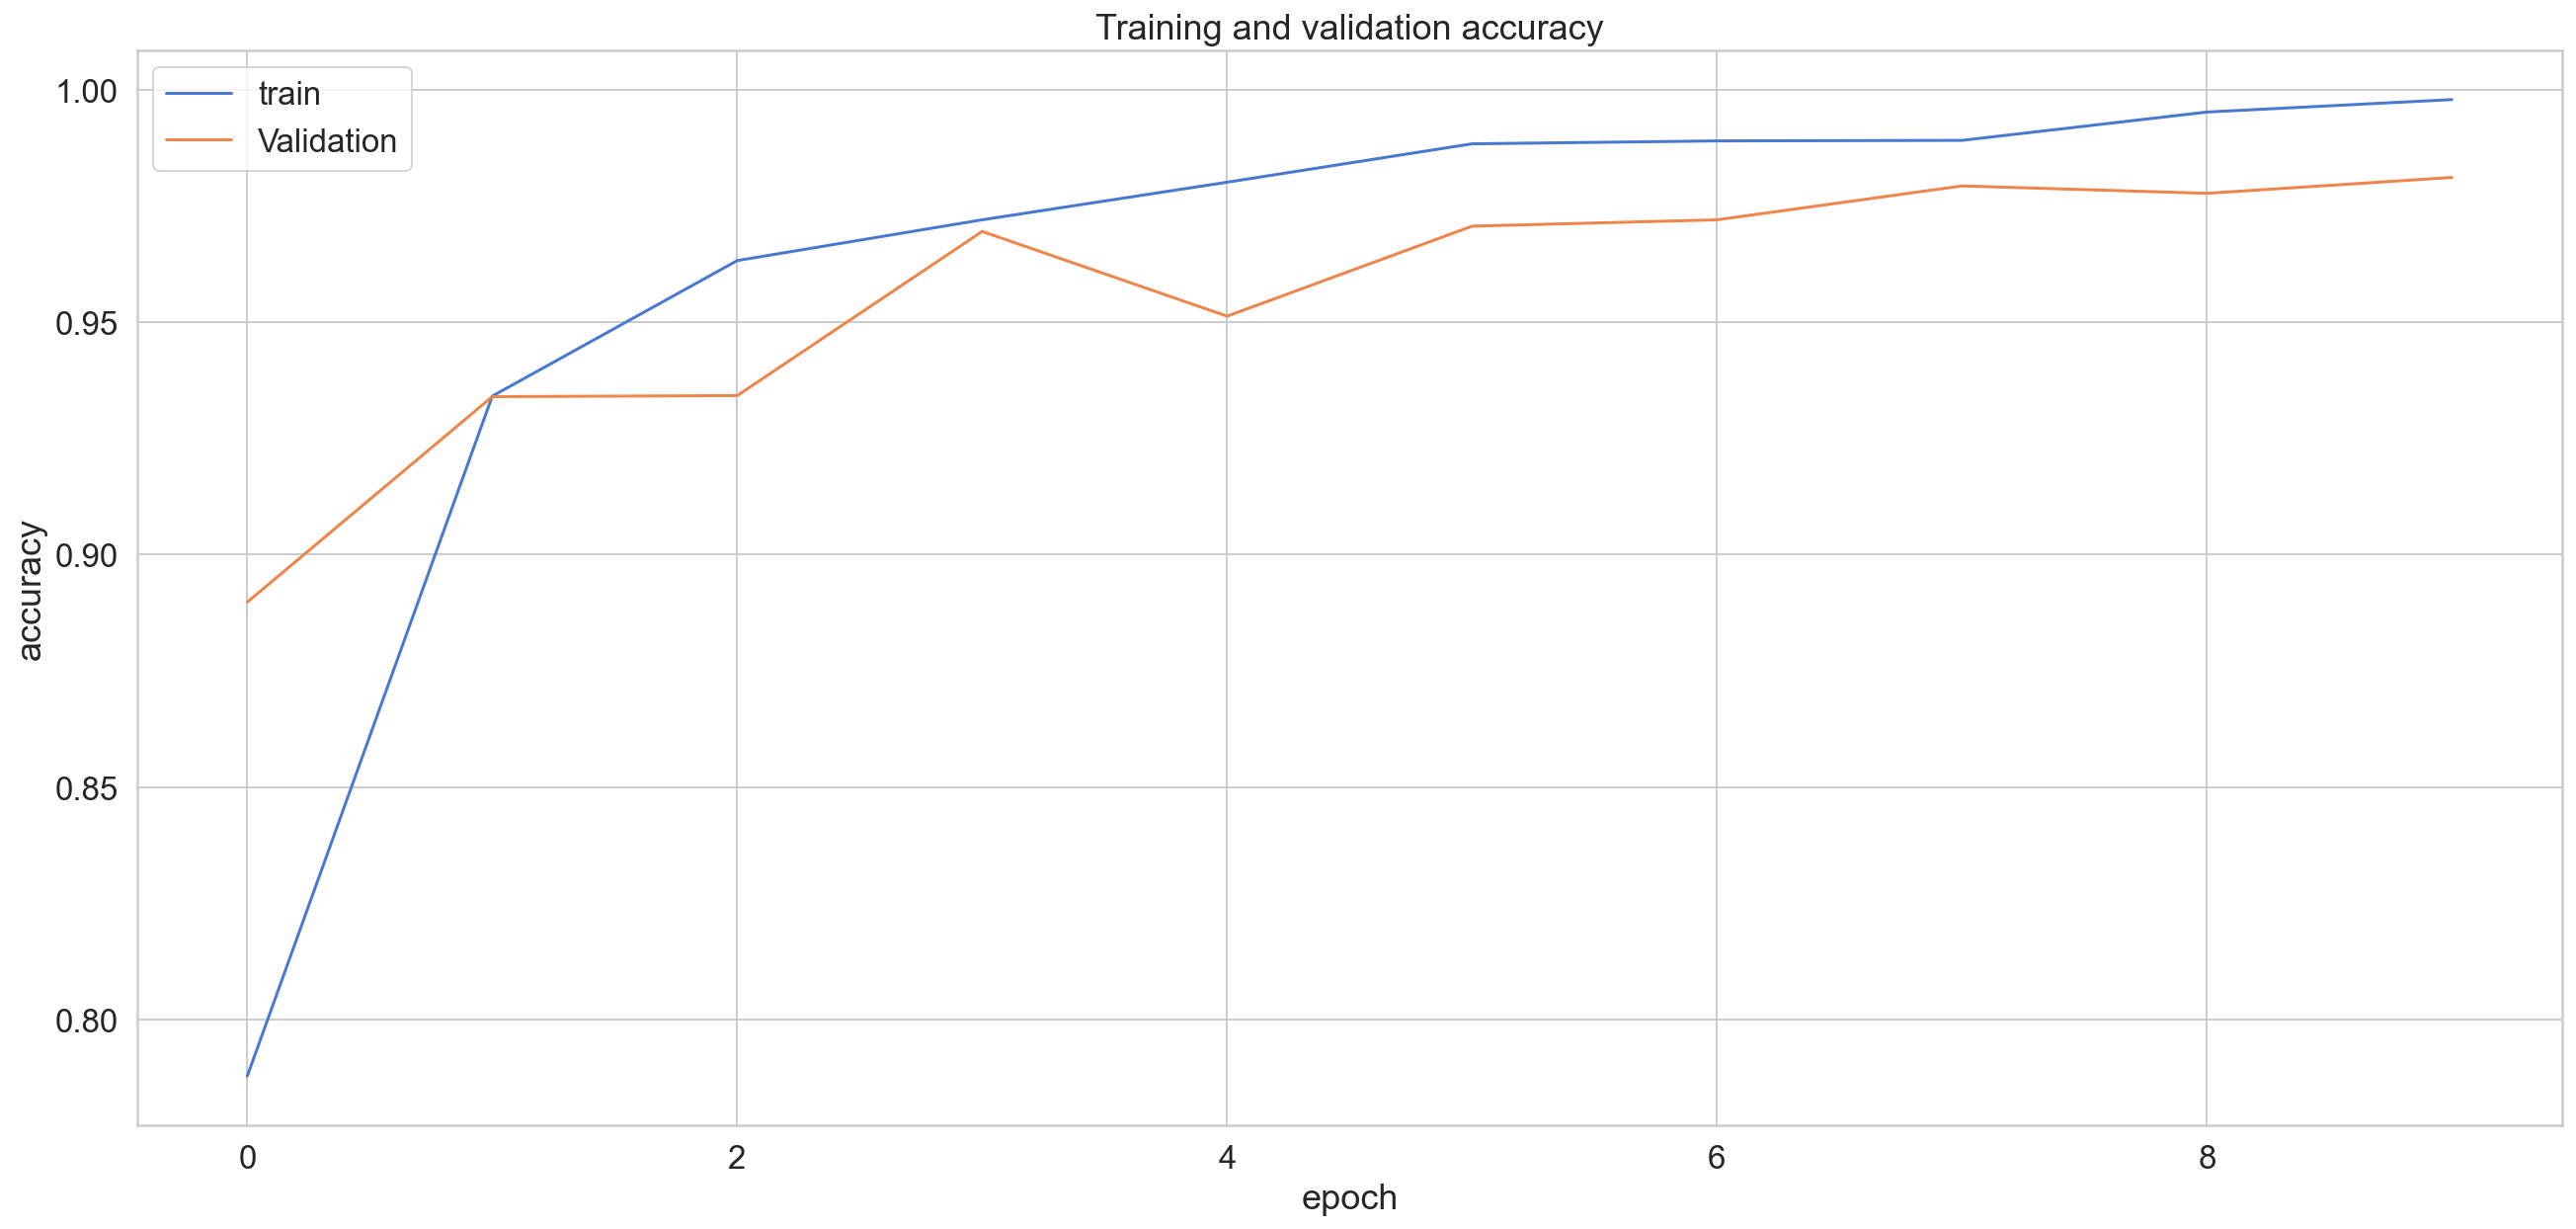

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

f1_score =  0.980926000274768
0.9808778000364232
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       1.00      0.98      0.99      1710
           2       0.94      0.94      0.94       614
           3       0.94      0.94      0.94       502
           4       0.99      0.99      0.99       300
           5       0.98      1.00      0.99       242

    accuracy                           0.98      5491
   macro avg       0.97      0.98      0.97      5491
weighted avg       0.98      0.98      0.98      5491



<AxesSubplot:>

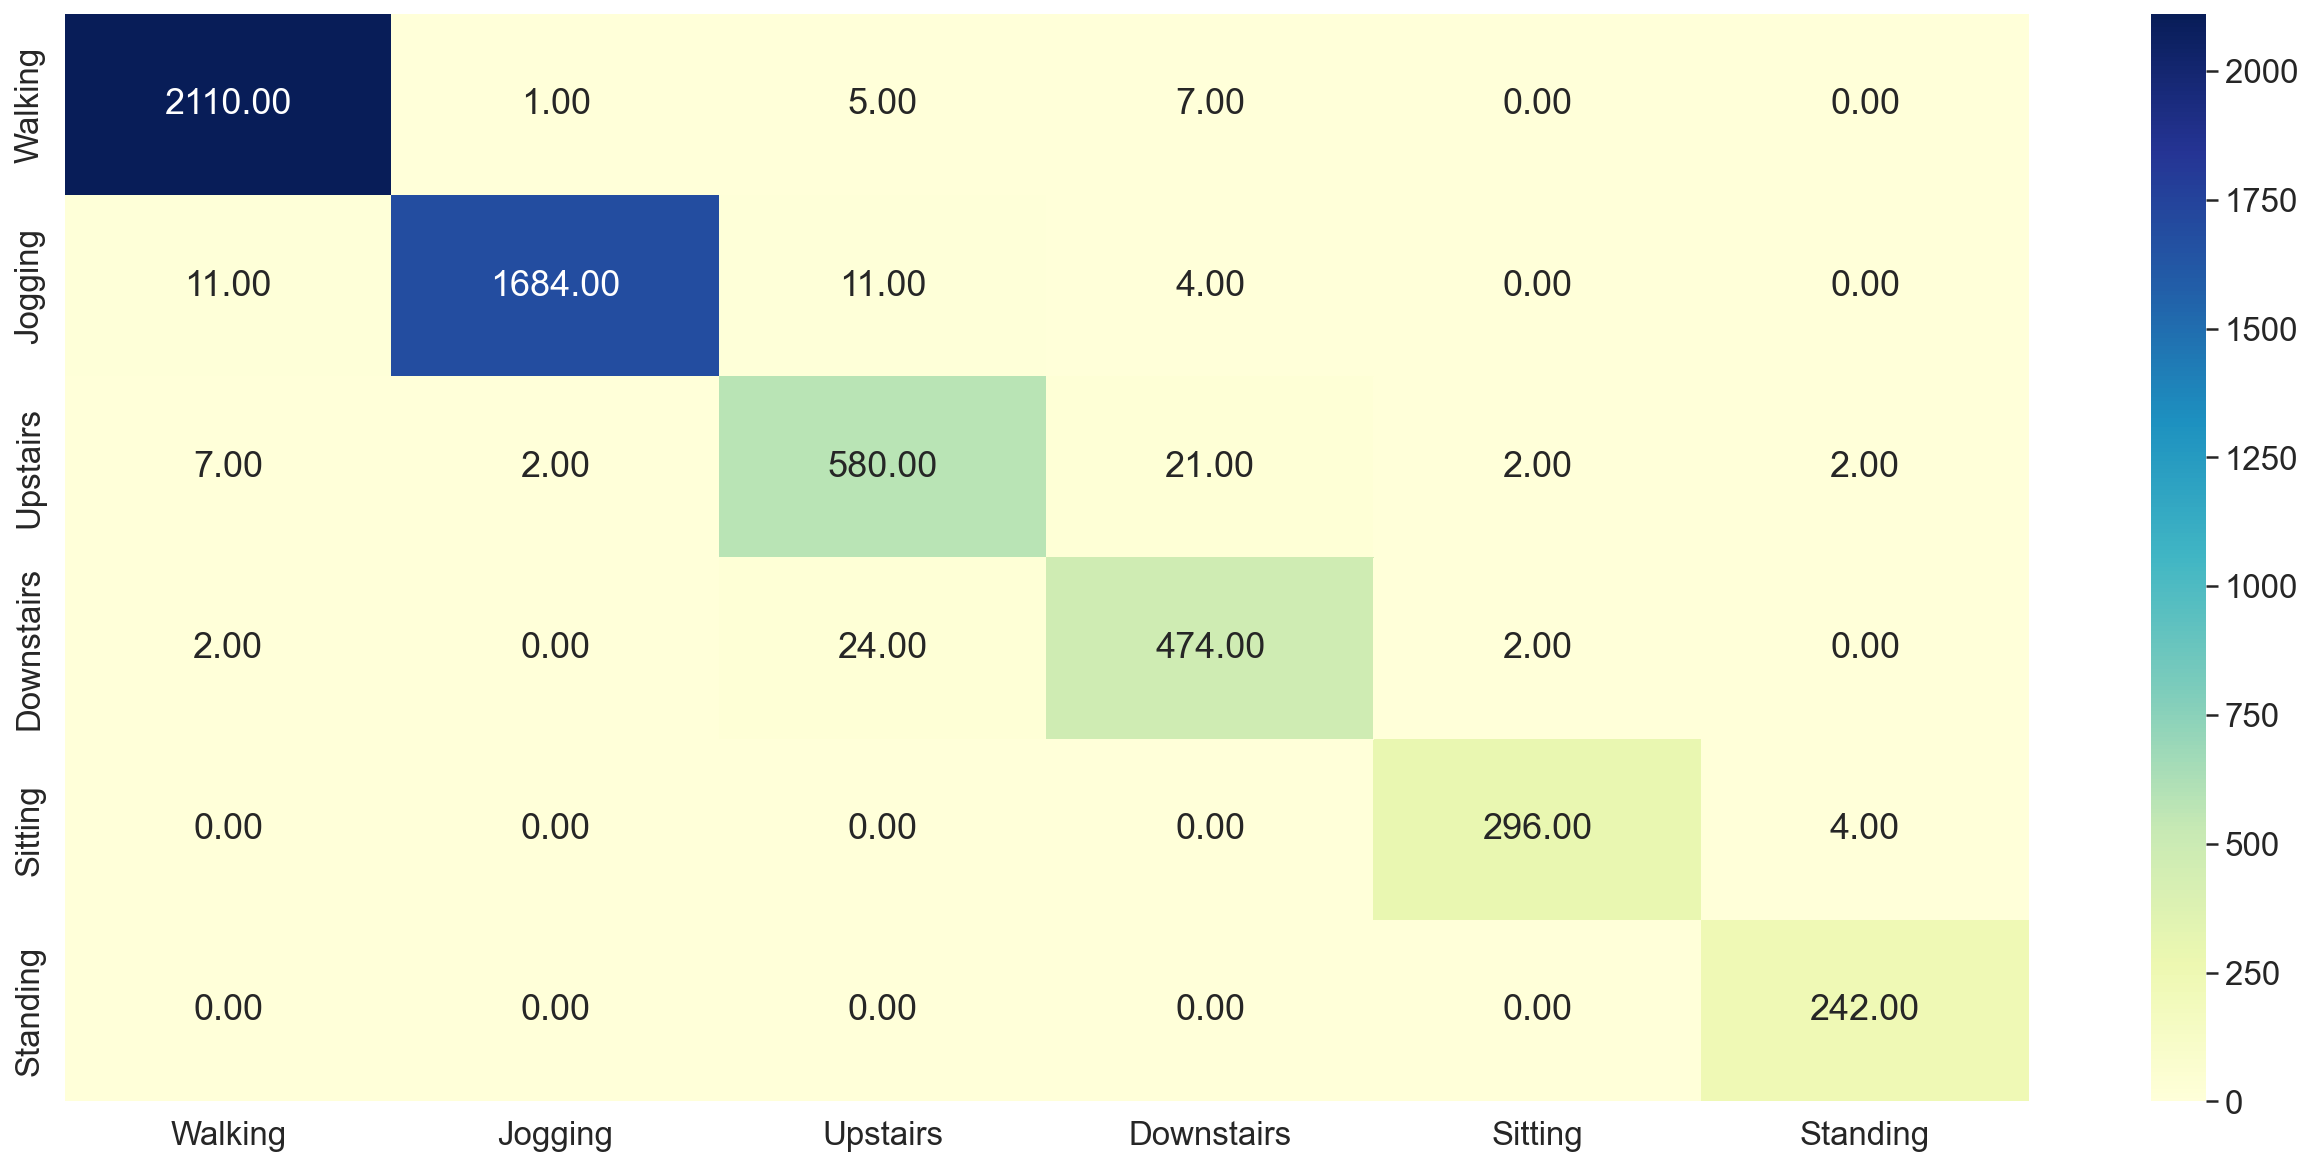

In [39]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')